In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Loading data

In [208]:
train = pd.read_csv(r"C:\Users\jvrdo\Downloads\training_set_features.csv", index_col='respondent_id')

In [209]:
test = pd.read_csv(r"C:\Users\jvrdo\Downloads\test_set_features.csv", index_col='respondent_id')

In [210]:
labels = pd.read_csv(r"C:\Users\jvrdo\Downloads\training_set_labels.csv", index_col='respondent_id')

In [211]:
seas_mean_risk_emp= train.groupby("employment_industry")["opinion_seas_risk"].mean()

race_seas_eff = train.groupby("race")["opinion_seas_vacc_effective"].mean() 

race_seas_sick = train.groupby("race")["opinion_seas_sick_from_vacc"].mean() 

In [212]:
race_seas_sick

race
Black                2.436108
Hispanic             2.703576
Other or Multiple    2.300000
White                2.024123
Name: opinion_seas_sick_from_vacc, dtype: float64

In [179]:

train= train.join(seas_mean_risk_emp, on="employment_industry",rsuffix='_r' )

In [ ]:
train= train.join(race_seas_eff, on="race",rsuffix='_r' )

In [194]:
train

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,opinion_seas_vacc_effective_r,opinion_seas_risk_r,opinion_seas_sick_from_vacc_s
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,2.0,oxchjgsf,Non-MSA,0.0,0.0,None,None,3.978607,2.602551,1.965413
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,3.978607,2.608486,1.965413
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0.0,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,3.978607,2.648184,1.965413
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,2.0,lrircsnp,"MSA, Principle City",0.0,0.0,None,None,3.978607,2.602551,1.965413
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,3.978607,2.904102,1.965413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,2.0,qufhixun,Non-MSA,0.0,0.0,None,None,3.978607,2.602551,1.965413
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,3.978607,3.107780,1.965413
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,lzgpxyit,"MSA, Not Principle City",0.0,0.0,None,None,3.978607,2.602551,1.965413


Imputation

In [8]:
num_cols = train.select_dtypes('number').columns

In [9]:
cat_cols = ['race', 'sex', 
       'marital_status', 'rent_or_own',  'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation']

In [10]:
ord_cols = ['age_group', 'education',  'income_poverty',
        'employment_status']

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from catboost import Pool, cv
from sklearn.metrics import roc_curve, roc_auc_score
import optuna
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()

Impute train

In [133]:
# Categorical columns None
for col in (cat_cols+ord_cols):
    train[col] = train[col].fillna(value='None')

In [134]:
for col in num_cols:
    train[col] = train[col].fillna(value=-1)

Impute test

In [158]:
# Categorical columns None
for col in (cat_cols+ord_cols):
    test[col] = test[col].fillna(value='None')

KeyError: 'race'

In [159]:
for col in num_cols:
    test[col] = test[col].fillna(value=-1)

Feature Engineering

In [49]:
# Creating a new feature based on opinion of vaccine effectiveness
def good_opinion_h1n1(train):  
    if train['opinion_h1n1_vacc_effective'] > 3:
        return 1
    else:
        return 0
    
    
def good_opinion_season(train):  
    if train['opinion_seas_vacc_effective'] > 3:
        return 1
    else:
        return 0

def risk_season(train):  
    if train['opinion_seas_sick_from_vacc'] > 3:
        return 1
    else:
        return 0
    
def risk_h1n1(train):  
    if train['opinion_h1n1_sick_from_vacc'] > 3:
        return 1
    else:
        return 0
    
def risk_get_h1n1(train):
    if train["opinion_h1n1_risk"] > 3:
        return 1
    else:
        return 0
    
def risk_get_flu(train):
    if train["opinion_seas_risk"] > 3:
        return 1
    else:
        return 0
    
def concerned(train):
    if train["h1n1_concern"] > 3:
        return 1
    else:
        return 0

In [50]:
train['good_opinion_h1n1'] = train.apply(lambda train: good_opinion_h1n1(train), axis=1)

train['good_opinion_season'] = train.apply(lambda train: good_opinion_season(train), axis=1)

train["Concerned"]= train.apply(lambda train: concerned(train), axis= 1)

In [51]:
train[ord_cols]

,age_group,education,income_poverty,employment_status
respondent_id,,,,
0,55 - 64 Years,< 12 Years,Below Poverty,Not in Labor Force
1,35 - 44 Years,12 Years,Below Poverty,Employed
2,18 - 34 Years,College Graduate,"<= $75,000, Above Poverty",Employed
3,65+ Years,12 Years,Below Poverty,Not in Labor Force
4,45 - 54 Years,Some College,"<= $75,000, Above Poverty",Employed
...,...,...,...,...
26702,65+ Years,Some College,"<= $75,000, Above Poverty",Not in Labor Force
26703,18 - 34 Years,College Graduate,"<= $75,000, Above Poverty",Employed
26704,55 - 64 Years,Some College,None,None


In [16]:
train=pd.get_dummies(train, columns=cat_cols)


In [142]:
train[ord_cols]= oe.fit_transform(train[ord_cols])

Train test split

In [201]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    train,
    labels,
    test_size=0.30,
    shuffle=True,
    random_state=68
)


In [144]:
# Get the index number of categorical features
categorical_features_indices = np.where(X_train.dtypes != float)[0]

CatBoost

In [145]:
train_dataset = Pool(data=X_train,
                     label=y_train.h1n1_vaccine,
                     cat_features = categorical_features_indices)

In [31]:
def objective(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,700,1000,1200,1300,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10,20),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10,15),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
         'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

    scores = cv(train_dataset,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False)

    return scores['test-AUC-mean'].max()

In [32]:
sampler = optuna.samplers.TPESampler(seed=68)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2022-07-16 15:39:31,930] A new study created in memory with name: no-name-f7d8e94b-57c6-4cc3-b19d-fd9f0510c638
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(


Training on fold [0/5]

bestTest = 0.4303044062
bestIteration = 104

Training on fold [1/5]

bestTest = 0.4215859411
bestIteration = 141

Training on fold [2/5]

bestTest = 0.4294144143
bestIteration = 192

Training on fold [3/5]

bestTest = 0.4302298332
bestIteration = 95

Training on fold [4/5]


[I 2022-07-16 15:39:33,927] Trial 0 finished with value: 0.8625042810932199 and parameters: {'iterations': 1200, 'learning_rate': 0.27993591089710923, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.001991194871120998, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8625042810932199.



bestTest = 0.4300377323
bestIteration = 116

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4293915449
bestIteration = 265

Training on fold [1/5]

bestTest = 0.4221458729
bestIteration = 291

Training on fold [2/5]

bestTest = 0.4315867513
bestIteration = 268

Training on fold [3/5]

bestTest = 0.4300834897
bestIteration = 173

Training on fold [4/5]


[I 2022-07-16 15:39:37,058] Trial 1 finished with value: 0.8630154185933563 and parameters: {'iterations': 1500, 'learning_rate': 0.10842629332974436, 'random_strength': 4, 'bagging_temperature': 1, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.028402775147703313, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8630154185933563.



bestTest = 0.4312099262
bestIteration = 294

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4268631073
bestIteration = 147

Training on fold [1/5]

bestTest = 0.4226052437
bestIteration = 115

Training on fold [2/5]

bestTest = 0.432100999
bestIteration = 94

Training on fold [3/5]

bestTest = 0.4246456516
bestIteration = 153

Training on fold [4/5]


[I 2022-07-16 15:39:46,718] Trial 2 finished with value: 0.8639176148745434 and parameters: {'iterations': 200, 'learning_rate': 0.23559884921762703, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.027330135035255495, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.8639176148745434.



bestTest = 0.4309377804
bestIteration = 89

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4279449381
bestIteration = 131

Training on fold [1/5]

bestTest = 0.4209373091
bestIteration = 183

Training on fold [2/5]

bestTest = 0.4320394548
bestIteration = 165

Training on fold [3/5]

bestTest = 0.4273397509
bestIteration = 143

Training on fold [4/5]


[I 2022-07-16 15:39:58,538] Trial 3 finished with value: 0.8634832218431729 and parameters: {'iterations': 1000, 'learning_rate': 0.194974145539544, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 1.300471404766049e-07, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.8639176148745434.



bestTest = 0.4301928903
bestIteration = 136

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4303080417
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4254738211
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4348329902
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4274913542
bestIteration = 297

Training on fold [4/5]


[I 2022-07-16 15:40:02,471] Trial 4 finished with value: 0.862800896903094 and parameters: {'iterations': 300, 'learning_rate': 0.06928147101485782, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.00010293033487726667, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.8639176148745434.



bestTest = 0.431207203
bestIteration = 299

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4660840559
bestIteration = 98

Training on fold [1/5]

bestTest = 0.461188831
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4717143587
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4650365264
bestIteration = 99

Training on fold [4/5]


[I 2022-07-16 15:40:04,097] Trial 5 finished with value: 0.8609287418116509 and parameters: {'iterations': 100, 'learning_rate': 0.1307813521062255, 'random_strength': 2, 'bagging_temperature': 3, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 13.751833235431702, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8639176148745434.



bestTest = 0.4715011979
bestIteration = 98

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4287952935
bestIteration = 348

Training on fold [1/5]

bestTest = 0.42279947
bestIteration = 400

Training on fold [2/5]

bestTest = 0.4285356336
bestIteration = 568

Training on fold [3/5]

bestTest = 0.4253679324
bestIteration = 461

Training on fold [4/5]


[I 2022-07-16 15:40:48,917] Trial 6 finished with value: 0.8647544955239456 and parameters: {'iterations': 1500, 'learning_rate': 0.05805171287971286, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 2.6558249848041764, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 6 with value: 0.8647544955239456.



bestTest = 0.4275278356
bestIteration = 512

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4646437715
bestIteration = 121

Training on fold [1/5]

bestTest = 0.4519260416
bestIteration = 195

Training on fold [2/5]

bestTest = 0.4633602604
bestIteration = 141

Training on fold [3/5]

bestTest = 0.4626753027
bestIteration = 138

Training on fold [4/5]


[I 2022-07-16 15:40:51,285] Trial 7 finished with value: 0.8632600507977722 and parameters: {'iterations': 1300, 'learning_rate': 0.1807096213514747, 'random_strength': 4, 'bagging_temperature': 3, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 4.9369231964322795, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8647544955239456.



bestTest = 0.4639969945
bestIteration = 170

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4338268932
bestIteration = 1174

Training on fold [1/5]

bestTest = 0.4295563045
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.4389100369
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.4302403835
bestIteration = 1199

Training on fold [4/5]


[I 2022-07-16 15:41:07,659] Trial 8 finished with value: 0.8611337286491209 and parameters: {'iterations': 1200, 'learning_rate': 0.01226996693484591, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 9.501510078266123e-06, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 6 with value: 0.8647544955239456.



bestTest = 0.4369376552
bestIteration = 1199

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.5698880999
bestIteration = 99

Training on fold [1/5]

bestTest = 0.5719671926
bestIteration = 99

Training on fold [2/5]

bestTest = 0.5748295806
bestIteration = 99

Training on fold [3/5]

bestTest = 0.5662757913
bestIteration = 99

Training on fold [4/5]


[I 2022-07-16 15:41:15,690] Trial 9 finished with value: 0.8255509425985756 and parameters: {'iterations': 100, 'learning_rate': 0.007429919004710596, 'random_strength': 8, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 1.1694576328936887e-07, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 6 with value: 0.8647544955239456.



bestTest = 0.5776049298
bestIteration = 99

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4608934193
bestIteration = 432

Training on fold [1/5]

bestTest = 0.4542212611
bestIteration = 368

Training on fold [2/5]

bestTest = 0.4653638427
bestIteration = 351

Training on fold [3/5]

bestTest = 0.4608350465
bestIteration = 373

Training on fold [4/5]


[I 2022-07-16 15:42:00,669] Trial 10 finished with value: 0.8635703619103747 and parameters: {'iterations': 500, 'learning_rate': 0.07030691356337633, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 67.55513953843523, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8647544955239456.



bestTest = 0.4659561739
bestIteration = 401

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4257126955
bestIteration = 129

Training on fold [1/5]

bestTest = 0.4211593999
bestIteration = 97

Training on fold [2/5]

bestTest = 0.4267705599
bestIteration = 145

Training on fold [3/5]

bestTest = 0.4254746258
bestIteration = 73

Training on fold [4/5]


[I 2022-07-16 15:42:14,976] Trial 11 finished with value: 0.8651925858219425 and parameters: {'iterations': 200, 'learning_rate': 0.2757375958594691, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.14700033488450495, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 11 with value: 0.8651925858219425.



bestTest = 0.4279687273
bestIteration = 146

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4259671152
bestIteration = 95

Training on fold [1/5]

bestTest = 0.4209954457
bestIteration = 100

Training on fold [2/5]

bestTest = 0.4261745188
bestIteration = 113

Training on fold [3/5]

bestTest = 0.4273656369
bestIteration = 50

Training on fold [4/5]


[I 2022-07-16 15:42:27,239] Trial 12 finished with value: 0.8647483306817765 and parameters: {'iterations': 200, 'learning_rate': 0.29381704597490466, 'random_strength': 1, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.5095295221450813, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 11 with value: 0.8651925858219425.



bestTest = 0.4287193928
bestIteration = 108

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4267645818
bestIteration = 118

Training on fold [1/5]

bestTest = 0.4201054387
bestIteration = 141

Training on fold [2/5]

bestTest = 0.431566869
bestIteration = 138

Training on fold [3/5]

bestTest = 0.4236425199
bestIteration = 127

Training on fold [4/5]


[I 2022-07-16 15:42:42,892] Trial 13 finished with value: 0.8644864752573496 and parameters: {'iterations': 1500, 'learning_rate': 0.23445822932054491, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.29185440909668253, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 11 with value: 0.8651925858219425.



bestTest = 0.4289016475
bestIteration = 130

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4239742885
bestIteration = 330

Training on fold [1/5]

bestTest = 0.4221573869
bestIteration = 323

Training on fold [2/5]

bestTest = 0.4290167942
bestIteration = 355

Training on fold [3/5]

bestTest = 0.4259608587
bestIteration = 289

Training on fold [4/5]


[I 2022-07-16 15:43:18,271] Trial 14 finished with value: 0.8651194411216512 and parameters: {'iterations': 700, 'learning_rate': 0.0737500885506709, 'random_strength': 1, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.8542639505816968, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 11 with value: 0.8651925858219425.



bestTest = 0.429793576
bestIteration = 290

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4578029068
bestIteration = 181

Training on fold [1/5]

bestTest = 0.4520792848
bestIteration = 220

Training on fold [2/5]

bestTest = 0.4625991964
bestIteration = 180

Training on fold [3/5]

bestTest = 0.4594143432
bestIteration = 133

Training on fold [4/5]


[I 2022-07-16 15:43:39,573] Trial 15 finished with value: 0.8650273427790367 and parameters: {'iterations': 700, 'learning_rate': 0.13959295341938688, 'random_strength': 1, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.007021984804640195, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 11 with value: 0.8651925858219425.



bestTest = 0.4604200526
bestIteration = 205

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.424801554
bestIteration = 258

Training on fold [1/5]

bestTest = 0.4190515558
bestIteration = 325

Training on fold [2/5]

bestTest = 0.4295361044
bestIteration = 308

Training on fold [3/5]

bestTest = 0.4261551047
bestIteration = 251

Training on fold [4/5]


[I 2022-07-16 15:44:10,095] Trial 16 finished with value: 0.8652199915501496 and parameters: {'iterations': 700, 'learning_rate': 0.10012360248348064, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.3230131740157611, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 16 with value: 0.8652199915501496.



bestTest = 0.4287518773
bestIteration = 228

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4269537875
bestIteration = 128

Training on fold [1/5]

bestTest = 0.4207482005
bestIteration = 129

Training on fold [2/5]

bestTest = 0.4310944201
bestIteration = 124

Training on fold [3/5]

bestTest = 0.4243837318
bestIteration = 124

Training on fold [4/5]


[I 2022-07-16 15:44:25,694] Trial 17 finished with value: 0.8647166789252335 and parameters: {'iterations': 200, 'learning_rate': 0.17886862449617366, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0002893322648060348, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 16 with value: 0.8652199915501496.



bestTest = 0.4283089092
bestIteration = 153

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4599058655
bestIteration = 97

Training on fold [1/5]

bestTest = 0.4538230147
bestIteration = 89

Training on fold [2/5]

bestTest = 0.462893531
bestIteration = 121

Training on fold [3/5]

bestTest = 0.4599287686
bestIteration = 127

Training on fold [4/5]


[I 2022-07-16 15:44:39,239] Trial 18 finished with value: 0.8643450269801389 and parameters: {'iterations': 700, 'learning_rate': 0.24093380809270865, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.11193806124762479, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 16 with value: 0.8652199915501496.



bestTest = 0.4614484674
bestIteration = 118

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4296538982
bestIteration = 174

Training on fold [1/5]

bestTest = 0.4251542958
bestIteration = 189

Training on fold [2/5]

bestTest = 0.4271522864
bestIteration = 336

Training on fold [3/5]

bestTest = 0.426960893
bestIteration = 187

Training on fold [4/5]


[I 2022-07-16 15:44:42,585] Trial 19 finished with value: 0.8634708894851068 and parameters: {'iterations': 500, 'learning_rate': 0.1159562016937926, 'random_strength': 6, 'bagging_temperature': 0, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 7.347359489511391e-06, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 16 with value: 0.8652199915501496.



bestTest = 0.4329814664
bestIteration = 204

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4263916941
bestIteration = 130

Training on fold [1/5]

bestTest = 0.4187442016
bestIteration = 152

Training on fold [2/5]

bestTest = 0.4293635074
bestIteration = 121

Training on fold [3/5]

bestTest = 0.4267625242
bestIteration = 108

Training on fold [4/5]


[I 2022-07-16 15:44:55,268] Trial 20 finished with value: 0.8652154011157613 and parameters: {'iterations': 1000, 'learning_rate': 0.21017216303016012, 'random_strength': 3, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 86.49974565825786, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 16 with value: 0.8652199915501496.



bestTest = 0.4282548609
bestIteration = 169

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4260356843
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4254367555
bestIteration = 89

Training on fold [2/5]

bestTest = 0.4244990307
bestIteration = 257

Training on fold [3/5]

bestTest = 0.424285866
bestIteration = 105

Training on fold [4/5]


[I 2022-07-16 15:45:08,960] Trial 21 finished with value: 0.8647785961836985 and parameters: {'iterations': 1000, 'learning_rate': 0.2704787058540193, 'random_strength': 3, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 52.29914991957594, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 16 with value: 0.8652199915501496.



bestTest = 0.429138123
bestIteration = 138

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4236307936
bestIteration = 120

Training on fold [1/5]

bestTest = 0.42121602
bestIteration = 145

Training on fold [2/5]

bestTest = 0.4274736181
bestIteration = 154

Training on fold [3/5]

bestTest = 0.4256554167
bestIteration = 115

Training on fold [4/5]


[I 2022-07-16 15:45:22,728] Trial 22 finished with value: 0.8651305184150078 and parameters: {'iterations': 1000, 'learning_rate': 0.20512830666732826, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 5.753820253542187, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 16 with value: 0.8652199915501496.



bestTest = 0.4282849239
bestIteration = 152

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.42563647
bestIteration = 137

Training on fold [1/5]

bestTest = 0.4198931594
bestIteration = 170

Training on fold [2/5]

bestTest = 0.4285029341
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4263669368
bestIteration = 207

Training on fold [4/5]


[I 2022-07-16 15:45:39,186] Trial 23 finished with value: 0.8650042183882153 and parameters: {'iterations': 1300, 'learning_rate': 0.15876605864882465, 'random_strength': 2, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.08310429060310566, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 16 with value: 0.8652199915501496.



bestTest = 0.4282680213
bestIteration = 189

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4279620559
bestIteration = 113

Training on fold [1/5]

bestTest = 0.4210614257
bestIteration = 134

Training on fold [2/5]

bestTest = 0.4251284723
bestIteration = 193

Training on fold [3/5]

bestTest = 0.4231317882
bestIteration = 110

Training on fold [4/5]


[I 2022-07-16 15:45:50,090] Trial 24 finished with value: 0.8649644606475441 and parameters: {'iterations': 300, 'learning_rate': 0.2603253094502179, 'random_strength': 3, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0043432818615556775, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 16 with value: 0.8652199915501496.



bestTest = 0.4298653418
bestIteration = 117

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4249190648
bestIteration = 136

Training on fold [1/5]

bestTest = 0.4229592427
bestIteration = 109

Training on fold [2/5]

bestTest = 0.4291748578
bestIteration = 120

Training on fold [3/5]

bestTest = 0.4252969139
bestIteration = 146

Training on fold [4/5]


[I 2022-07-16 15:46:06,427] Trial 25 finished with value: 0.8649026026264757 and parameters: {'iterations': 700, 'learning_rate': 0.2113531874991687, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 84.7519051824865, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 16 with value: 0.8652199915501496.



bestTest = 0.427742063
bestIteration = 145

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4279386675
bestIteration = 135

Training on fold [1/5]

bestTest = 0.4213774972
bestIteration = 166

Training on fold [2/5]

bestTest = 0.4338551544
bestIteration = 125

Training on fold [3/5]

bestTest = 0.4254766667
bestIteration = 126

Training on fold [4/5]


[I 2022-07-16 15:46:20,284] Trial 26 finished with value: 0.8641724372074912 and parameters: {'iterations': 200, 'learning_rate': 0.15871159231426457, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 1.1879583884353406, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 16 with value: 0.8652199915501496.



bestTest = 0.4266772883
bestIteration = 199

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4617697185
bestIteration = 283

Training on fold [1/5]

bestTest = 0.4539640076
bestIteration = 338

Training on fold [2/5]

bestTest = 0.4630507751
bestIteration = 289

Training on fold [3/5]

bestTest = 0.4635495225
bestIteration = 196

Training on fold [4/5]


[I 2022-07-16 15:46:25,178] Trial 27 finished with value: 0.8635177048459612 and parameters: {'iterations': 1000, 'learning_rate': 0.0945565127510036, 'random_strength': 5, 'bagging_temperature': 6, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 11.030700147905396, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 16 with value: 0.8652199915501496.



bestTest = 0.4628647731
bestIteration = 307

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4273013295
bestIteration = 89

Training on fold [1/5]

bestTest = 0.4205339264
bestIteration = 146

Training on fold [2/5]

bestTest = 0.4380522478
bestIteration = 47

Training on fold [3/5]

bestTest = 0.4273592148
bestIteration = 60

Training on fold [4/5]


[I 2022-07-16 15:46:26,575] Trial 28 finished with value: 0.8626688520697746 and parameters: {'iterations': 700, 'learning_rate': 0.29837251858949926, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.020373223011668724, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 16 with value: 0.8652199915501496.



bestTest = 0.4296499809
bestIteration = 75

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4310162336
bestIteration = 76

Training on fold [1/5]

bestTest = 0.4187158834
bestIteration = 127

Training on fold [2/5]

bestTest = 0.432173881
bestIteration = 71

Training on fold [3/5]

bestTest = 0.4288774728
bestIteration = 53

Training on fold [4/5]


[I 2022-07-16 15:46:28,186] Trial 29 finished with value: 0.8625159753519697 and parameters: {'iterations': 1200, 'learning_rate': 0.26395380540127117, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.001010717504930939, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 16 with value: 0.8652199915501496.



bestTest = 0.4318872173
bestIteration = 74

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4454448357
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4453805226
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4529671129
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4428753367
bestIteration = 199

Training on fold [4/5]


[I 2022-07-16 15:46:51,530] Trial 30 finished with value: 0.8543079482326554 and parameters: {'iterations': 200, 'learning_rate': 0.035211843064830314, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.15346032944821053, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 16 with value: 0.8652199915501496.



bestTest = 0.4514570572
bestIteration = 199

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4236393212
bestIteration = 121

Training on fold [1/5]

bestTest = 0.4213566299
bestIteration = 126

Training on fold [2/5]

bestTest = 0.4258000673
bestIteration = 199

Training on fold [3/5]

bestTest = 0.426505149
bestIteration = 99

Training on fold [4/5]


[I 2022-07-16 15:47:04,573] Trial 31 finished with value: 0.8653687546169854 and parameters: {'iterations': 1000, 'learning_rate': 0.21474137659552017, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 15.54645056519929, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 31 with value: 0.8653687546169854.



bestTest = 0.4283203935
bestIteration = 145

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4242259976
bestIteration = 132

Training on fold [1/5]

bestTest = 0.4228329367
bestIteration = 98

Training on fold [2/5]

bestTest = 0.4311734858
bestIteration = 97

Training on fold [3/5]

bestTest = 0.4286937375
bestIteration = 80

Training on fold [4/5]


[I 2022-07-16 15:47:15,230] Trial 32 finished with value: 0.8644241168236961 and parameters: {'iterations': 1000, 'learning_rate': 0.21636072395369368, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 27.389383536011074, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 31 with value: 0.8653687546169854.



bestTest = 0.427611018
bestIteration = 148

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4258684223
bestIteration = 86

Training on fold [1/5]

bestTest = 0.421900975
bestIteration = 102

Training on fold [2/5]

bestTest = 0.4303642004
bestIteration = 90

Training on fold [3/5]

bestTest = 0.4282808092
bestIteration = 94

Training on fold [4/5]


[I 2022-07-16 15:47:25,374] Trial 33 finished with value: 0.8642915678266204 and parameters: {'iterations': 1000, 'learning_rate': 0.24657837365737365, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 2.6266289233354803, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 31 with value: 0.8653687546169854.



bestTest = 0.4277937863
bestIteration = 118

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4262357749
bestIteration = 149

Training on fold [1/5]

bestTest = 0.4220457128
bestIteration = 149

Training on fold [2/5]

bestTest = 0.4288625616
bestIteration = 171

Training on fold [3/5]

bestTest = 0.426157654
bestIteration = 111

Training on fold [4/5]


[I 2022-07-16 15:47:39,836] Trial 34 finished with value: 0.8645230552801155 and parameters: {'iterations': 1000, 'learning_rate': 0.22737035597106608, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 14.226151799243935, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 31 with value: 0.8653687546169854.



bestTest = 0.4283899123
bestIteration = 197

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4280243633
bestIteration = 98

Training on fold [1/5]

bestTest = 0.4210687956
bestIteration = 94

Training on fold [2/5]

bestTest = 0.4332866657
bestIteration = 87

Training on fold [3/5]

bestTest = 0.4274976322
bestIteration = 89

Training on fold [4/5]


[I 2022-07-16 15:47:41,365] Trial 35 finished with value: 0.8632049472796768 and parameters: {'iterations': 1000, 'learning_rate': 0.28011069285114293, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.9228720410213881, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 31 with value: 0.8653687546169854.



bestTest = 0.4312055218
bestIteration = 95

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4281725995
bestIteration = 153

Training on fold [1/5]

bestTest = 0.4220725176
bestIteration = 189

Training on fold [2/5]

bestTest = 0.4286634673
bestIteration = 221

Training on fold [3/5]

bestTest = 0.428035055
bestIteration = 137

Training on fold [4/5]


[I 2022-07-16 15:47:56,821] Trial 36 finished with value: 0.8632605816431237 and parameters: {'iterations': 300, 'learning_rate': 0.1852017482059674, 'random_strength': 10, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.04027123070440849, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 31 with value: 0.8653687546169854.



bestTest = 0.4314482131
bestIteration = 160

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4374854041
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4347199294
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4433187312
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4343745095
bestIteration = 99

Training on fold [4/5]


[I 2022-07-16 15:48:05,331] Trial 37 finished with value: 0.8584084018434932 and parameters: {'iterations': 100, 'learning_rate': 0.10494329236766387, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 2.502013315436424, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 31 with value: 0.8653687546169854.



bestTest = 0.4420704863
bestIteration = 99

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4594446183
bestIteration = 154

Training on fold [1/5]

bestTest = 0.4533603742
bestIteration = 172

Training on fold [2/5]

bestTest = 0.4619378079
bestIteration = 139

Training on fold [3/5]

bestTest = 0.4601363104
bestIteration = 129

Training on fold [4/5]


[I 2022-07-16 15:48:18,989] Trial 38 finished with value: 0.8648648080191428 and parameters: {'iterations': 200, 'learning_rate': 0.1682134686217847, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 2.5546572748793384e-08, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 31 with value: 0.8653687546169854.



bestTest = 0.4603535469
bestIteration = 161

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4291105419
bestIteration = 100

Training on fold [1/5]

bestTest = 0.4255281678
bestIteration = 121

Training on fold [2/5]

bestTest = 0.4299094556
bestIteration = 112

Training on fold [3/5]

bestTest = 0.4262546224
bestIteration = 140

Training on fold [4/5]


[I 2022-07-16 15:48:21,135] Trial 39 finished with value: 0.8634084896145264 and parameters: {'iterations': 1300, 'learning_rate': 0.198340646663188, 'random_strength': 5, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 6.939254637140129, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 31 with value: 0.8653687546169854.



bestTest = 0.4272788689
bestIteration = 150

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4262421318
bestIteration = 239

Training on fold [1/5]

bestTest = 0.4220916938
bestIteration = 249

Training on fold [2/5]

bestTest = 0.4287773867
bestIteration = 302

Training on fold [3/5]

bestTest = 0.4256061153
bestIteration = 223

Training on fold [4/5]


[I 2022-07-16 15:48:41,979] Trial 40 finished with value: 0.8646314085820432 and parameters: {'iterations': 1200, 'learning_rate': 0.13219846524060902, 'random_strength': 4, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 22.20575619911856, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 31 with value: 0.8653687546169854.



bestTest = 0.4311548997
bestIteration = 179

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4237530276
bestIteration = 116

Training on fold [1/5]

bestTest = 0.4214411796
bestIteration = 134

Training on fold [2/5]

bestTest = 0.4261538509
bestIteration = 202

Training on fold [3/5]

bestTest = 0.426396327
bestIteration = 84

Training on fold [4/5]


[I 2022-07-16 15:48:53,722] Trial 41 finished with value: 0.8653673385165682 and parameters: {'iterations': 1000, 'learning_rate': 0.2058411472676317, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 5.9521780429263105, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 31 with value: 0.8653687546169854.



bestTest = 0.4277873876
bestIteration = 118

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4265308581
bestIteration = 114

Training on fold [1/5]

bestTest = 0.4188938266
bestIteration = 130

Training on fold [2/5]

bestTest = 0.4284826215
bestIteration = 157

Training on fold [3/5]

bestTest = 0.4272655119
bestIteration = 113

Training on fold [4/5]


[I 2022-07-16 15:49:04,312] Trial 42 finished with value: 0.8642549527496179 and parameters: {'iterations': 1000, 'learning_rate': 0.25215964314154105, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.29111896166305357, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 31 with value: 0.8653687546169854.



bestTest = 0.4312101782
bestIteration = 76

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4238244987
bestIteration = 121

Training on fold [1/5]

bestTest = 0.4195291395
bestIteration = 154

Training on fold [2/5]

bestTest = 0.4287177731
bestIteration = 91

Training on fold [3/5]

bestTest = 0.4236479689
bestIteration = 95

Training on fold [4/5]


[I 2022-07-16 15:49:14,844] Trial 43 finished with value: 0.8655851776302402 and parameters: {'iterations': 1000, 'learning_rate': 0.22449050217777933, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 2.0977699290854406, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 43 with value: 0.8655851776302402.



bestTest = 0.4295376619
bestIteration = 106

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4247298898
bestIteration = 110

Training on fold [1/5]

bestTest = 0.4196278617
bestIteration = 161

Training on fold [2/5]

bestTest = 0.4280483655
bestIteration = 190

Training on fold [3/5]

bestTest = 0.4242015667
bestIteration = 108

Training on fold [4/5]


[I 2022-07-16 15:49:27,355] Trial 44 finished with value: 0.8654220985461976 and parameters: {'iterations': 1000, 'learning_rate': 0.21678755098628283, 'random_strength': 1, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 28.445733527268168, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 43 with value: 0.8655851776302402.



bestTest = 0.4294401912
bestIteration = 121

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4253645577
bestIteration = 156

Training on fold [1/5]

bestTest = 0.4208215653
bestIteration = 125

Training on fold [2/5]

bestTest = 0.4274337402
bestIteration = 184

Training on fold [3/5]

bestTest = 0.4270010987
bestIteration = 121

Training on fold [4/5]


[I 2022-07-16 15:49:40,745] Trial 45 finished with value: 0.8648501289221588 and parameters: {'iterations': 1000, 'learning_rate': 0.18773276806602474, 'random_strength': 2, 'bagging_temperature': 3, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 2.5186349530679735, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 43 with value: 0.8655851776302402.



bestTest = 0.4296774891
bestIteration = 166

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4243228055
bestIteration = 145

Training on fold [1/5]

bestTest = 0.420571957
bestIteration = 125

Training on fold [2/5]

bestTest = 0.4278157571
bestIteration = 166

Training on fold [3/5]

bestTest = 0.4262342383
bestIteration = 101

Training on fold [4/5]


[I 2022-07-16 15:49:52,376] Trial 46 finished with value: 0.8650835992531223 and parameters: {'iterations': 1500, 'learning_rate': 0.22014877414704234, 'random_strength': 1, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 27.60159469206259, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 43 with value: 0.8655851776302402.



bestTest = 0.429722525
bestIteration = 113

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4635646305
bestIteration = 96

Training on fold [1/5]

bestTest = 0.4536590038
bestIteration = 130

Training on fold [2/5]

bestTest = 0.4607986227
bestIteration = 163

Training on fold [3/5]

bestTest = 0.4615525553
bestIteration = 89

Training on fold [4/5]


[I 2022-07-16 15:50:03,019] Trial 47 finished with value: 0.8632195226230985 and parameters: {'iterations': 1000, 'learning_rate': 0.2316812465257306, 'random_strength': 8, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 1.3036702379205562e-05, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 43 with value: 0.8655851776302402.



bestTest = 0.4629661381
bestIteration = 127

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4296453502
bestIteration = 177

Training on fold [1/5]

bestTest = 0.4212030688
bestIteration = 257

Training on fold [2/5]

bestTest = 0.4311416972
bestIteration = 236

Training on fold [3/5]

bestTest = 0.4279138406
bestIteration = 161

Training on fold [4/5]


[I 2022-07-16 15:50:06,014] Trial 48 finished with value: 0.8633225380544085 and parameters: {'iterations': 500, 'learning_rate': 0.14728836527094202, 'random_strength': 9, 'bagging_temperature': 4, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 6.781197735811021, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 43 with value: 0.8655851776302402.



bestTest = 0.4297246773
bestIteration = 169

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4294229674
bestIteration = 128

Training on fold [1/5]

bestTest = 0.4210403813
bestIteration = 172

Training on fold [2/5]

bestTest = 0.4292831122
bestIteration = 168

Training on fold [3/5]

bestTest = 0.42516717
bestIteration = 144

Training on fold [4/5]


[I 2022-07-16 15:50:08,478] Trial 49 finished with value: 0.8643375252899276 and parameters: {'iterations': 1000, 'learning_rate': 0.1722712869306427, 'random_strength': 1, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.5407782302952462, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 43 with value: 0.8655851776302402.



bestTest = 0.427458303
bestIteration = 154

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4256616381
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4231743692
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4344280625
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4269431864
bestIteration = 98

Training on fold [4/5]


[I 2022-07-16 15:50:16,683] Trial 50 finished with value: 0.8636481692251747 and parameters: {'iterations': 100, 'learning_rate': 0.19613813875902691, 'random_strength': 2, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 1.7077503319168332, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 43 with value: 0.8655851776302402.



bestTest = 0.4303413898
bestIteration = 99

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4254467267
bestIteration = 126

Training on fold [1/5]

bestTest = 0.4197712775
bestIteration = 128

Training on fold [2/5]

bestTest = 0.4295511731
bestIteration = 118

Training on fold [3/5]

bestTest = 0.4243861929
bestIteration = 105

Training on fold [4/5]


[I 2022-07-16 15:50:27,190] Trial 51 finished with value: 0.8650763966603872 and parameters: {'iterations': 1000, 'learning_rate': 0.22430098915596797, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 51.08383250255133, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 43 with value: 0.8655851776302402.



bestTest = 0.4309328968
bestIteration = 90

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4257950937
bestIteration = 102

Training on fold [1/5]

bestTest = 0.4204047426
bestIteration = 142

Training on fold [2/5]

bestTest = 0.4282069496
bestIteration = 179

Training on fold [3/5]

bestTest = 0.4250230002
bestIteration = 130

Training on fold [4/5]


[I 2022-07-16 15:50:41,273] Trial 52 finished with value: 0.8656327318151421 and parameters: {'iterations': 1000, 'learning_rate': 0.2080636308274448, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 96.50742148228932, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 52 with value: 0.8656327318151421.



bestTest = 0.4272728222
bestIteration = 182

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4251340817
bestIteration = 114

Training on fold [1/5]

bestTest = 0.4188389801
bestIteration = 169

Training on fold [2/5]

bestTest = 0.4261294748
bestIteration = 209

Training on fold [3/5]

bestTest = 0.4264655933
bestIteration = 89

Training on fold [4/5]


[I 2022-07-16 15:50:52,958] Trial 53 finished with value: 0.8657734887033441 and parameters: {'iterations': 1000, 'learning_rate': 0.24314087560877246, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 22.095321757665303, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 53 with value: 0.8657734887033441.



bestTest = 0.4269414231
bestIteration = 118

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4273075499
bestIteration = 115

Training on fold [1/5]

bestTest = 0.4216005203
bestIteration = 102

Training on fold [2/5]

bestTest = 0.4273598192
bestIteration = 214

Training on fold [3/5]

bestTest = 0.4259690044
bestIteration = 81

Training on fold [4/5]


[I 2022-07-16 15:51:04,581] Trial 54 finished with value: 0.8650963524072625 and parameters: {'iterations': 1000, 'learning_rate': 0.2406656542636649, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 28.88383573239311, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 53 with value: 0.8657734887033441.



bestTest = 0.4272378958
bestIteration = 166

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4256554715
bestIteration = 104

Training on fold [1/5]

bestTest = 0.4206965645
bestIteration = 128

Training on fold [2/5]

bestTest = 0.4309425978
bestIteration = 129

Training on fold [3/5]

bestTest = 0.4258435195
bestIteration = 106

Training on fold [4/5]


[I 2022-07-16 15:51:15,255] Trial 55 finished with value: 0.8648701479492011 and parameters: {'iterations': 1000, 'learning_rate': 0.20145867638246703, 'random_strength': 2, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 13.012633269270232, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 53 with value: 0.8657734887033441.



bestTest = 0.426083929
bestIteration = 186

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4598809265
bestIteration = 83

Training on fold [1/5]

bestTest = 0.4538311586
bestIteration = 117

Training on fold [2/5]

bestTest = 0.4592249796
bestIteration = 124

Training on fold [3/5]

bestTest = 0.4611358213
bestIteration = 73

Training on fold [4/5]


[I 2022-07-16 15:51:16,891] Trial 56 finished with value: 0.8640554090091601 and parameters: {'iterations': 1000, 'learning_rate': 0.24861498692651451, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 5.188061738217462, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 53 with value: 0.8657734887033441.



bestTest = 0.4649279365
bestIteration = 100

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4275864133
bestIteration = 57

Training on fold [1/5]

bestTest = 0.4209550547
bestIteration = 96

Training on fold [2/5]

bestTest = 0.4262668005
bestIteration = 175

Training on fold [3/5]

bestTest = 0.4287633457
bestIteration = 105

Training on fold [4/5]


[I 2022-07-16 15:51:27,010] Trial 57 finished with value: 0.8646228461391576 and parameters: {'iterations': 1000, 'learning_rate': 0.2819833897720272, 'random_strength': 2, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 58.119185641170034, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 53 with value: 0.8657734887033441.



bestTest = 0.4268357947
bestIteration = 123

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4251254235
bestIteration = 120

Training on fold [1/5]

bestTest = 0.4260412077
bestIteration = 74

Training on fold [2/5]

bestTest = 0.4264372483
bestIteration = 236

Training on fold [3/5]

bestTest = 0.4266823645
bestIteration = 116

Training on fold [4/5]


[I 2022-07-16 15:51:39,530] Trial 58 finished with value: 0.8646858291682257 and parameters: {'iterations': 1500, 'learning_rate': 0.2593785044478544, 'random_strength': 1, 'bagging_temperature': 2, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 99.54069751116207, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 53 with value: 0.8657734887033441.



bestTest = 0.4276565826
bestIteration = 109

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4262705868
bestIteration = 102

Training on fold [1/5]

bestTest = 0.4215850405
bestIteration = 101

Training on fold [2/5]

bestTest = 0.426748206
bestIteration = 172

Training on fold [3/5]

bestTest = 0.4256376609
bestIteration = 122

Training on fold [4/5]


[I 2022-07-16 15:51:49,303] Trial 59 finished with value: 0.8649539567897111 and parameters: {'iterations': 1000, 'learning_rate': 0.2363013254264037, 'random_strength': 1, 'bagging_temperature': 3, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 13.572949631175735, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 53 with value: 0.8657734887033441.



bestTest = 0.4291680064
bestIteration = 97

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4294621641
bestIteration = 89

Training on fold [1/5]

bestTest = 0.4197157397
bestIteration = 144

Training on fold [2/5]

bestTest = 0.4286551181
bestIteration = 181

Training on fold [3/5]

bestTest = 0.4269941982
bestIteration = 85

Training on fold [4/5]


[I 2022-07-16 15:51:51,221] Trial 60 finished with value: 0.8639797068355397 and parameters: {'iterations': 1000, 'learning_rate': 0.21776740715725126, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 4.607758880414898, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 53 with value: 0.8657734887033441.



bestTest = 0.4301181583
bestIteration = 141

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4257957561
bestIteration = 148

Training on fold [1/5]

bestTest = 0.419869798
bestIteration = 160

Training on fold [2/5]

bestTest = 0.4257038701
bestIteration = 323

Training on fold [3/5]

bestTest = 0.4262910108
bestIteration = 124

Training on fold [4/5]


[I 2022-07-16 15:52:07,288] Trial 61 finished with value: 0.8653474524133232 and parameters: {'iterations': 700, 'learning_rate': 0.20680709042352496, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 33.79709648686925, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 53 with value: 0.8657734887033441.



bestTest = 0.4299043205
bestIteration = 136

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.426279948
bestIteration = 161

Training on fold [1/5]

bestTest = 0.4217253436
bestIteration = 121

Training on fold [2/5]

bestTest = 0.4299027978
bestIteration = 189

Training on fold [3/5]

bestTest = 0.425153147
bestIteration = 150

Training on fold [4/5]


[I 2022-07-16 15:52:19,709] Trial 62 finished with value: 0.8642551896883571 and parameters: {'iterations': 700, 'learning_rate': 0.19122228952541245, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 37.55912350455491, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 53 with value: 0.8657734887033441.



bestTest = 0.4323903053
bestIteration = 105

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4257916721
bestIteration = 166

Training on fold [1/5]

bestTest = 0.4218754147
bestIteration = 124

Training on fold [2/5]

bestTest = 0.4281431978
bestIteration = 171

Training on fold [3/5]

bestTest = 0.4278237321
bestIteration = 91

Training on fold [4/5]


[I 2022-07-16 15:52:33,140] Trial 63 finished with value: 0.8646115569634771 and parameters: {'iterations': 300, 'learning_rate': 0.20927825218222573, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 19.82477735984825, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 53 with value: 0.8657734887033441.



bestTest = 0.4300003358
bestIteration = 151

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4253351798
bestIteration = 145

Training on fold [1/5]

bestTest = 0.4212554618
bestIteration = 163

Training on fold [2/5]

bestTest = 0.432007298
bestIteration = 104

Training on fold [3/5]

bestTest = 0.4277784852
bestIteration = 127

Training on fold [4/5]


[I 2022-07-16 15:52:45,314] Trial 64 finished with value: 0.8640910653770358 and parameters: {'iterations': 500, 'learning_rate': 0.23031506995791637, 'random_strength': 2, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 12.940371937141967, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 53 with value: 0.8657734887033441.



bestTest = 0.4288077835
bestIteration = 148

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.427404326
bestIteration = 176

Training on fold [1/5]

bestTest = 0.4200447168
bestIteration = 236

Training on fold [2/5]

bestTest = 0.4258989383
bestIteration = 261

Training on fold [3/5]

bestTest = 0.4259356949
bestIteration = 148

Training on fold [4/5]


[I 2022-07-16 15:53:02,841] Trial 65 finished with value: 0.8650476412131706 and parameters: {'iterations': 1300, 'learning_rate': 0.1775732260390827, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 4.011614627277099, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 53 with value: 0.8657734887033441.



bestTest = 0.43001478
bestIteration = 212

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4287083141
bestIteration = 152

Training on fold [1/5]

bestTest = 0.421836106
bestIteration = 190

Training on fold [2/5]

bestTest = 0.4340257053
bestIteration = 126

Training on fold [3/5]

bestTest = 0.4263479262
bestIteration = 133

Training on fold [4/5]


[I 2022-07-16 15:53:05,181] Trial 66 finished with value: 0.8628181689718444 and parameters: {'iterations': 700, 'learning_rate': 0.20576823750782414, 'random_strength': 7, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 94.5210420867664, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 53 with value: 0.8657734887033441.



bestTest = 0.4301856276
bestIteration = 151

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4265549023
bestIteration = 128

Training on fold [1/5]

bestTest = 0.4195233576
bestIteration = 145

Training on fold [2/5]

bestTest = 0.4285311187
bestIteration = 168

Training on fold [3/5]

bestTest = 0.4255043375
bestIteration = 110

Training on fold [4/5]


[I 2022-07-16 15:53:16,705] Trial 67 finished with value: 0.8646273609461692 and parameters: {'iterations': 1000, 'learning_rate': 0.2218464878585374, 'random_strength': 2, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 1.3683972185063058, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 53 with value: 0.8657734887033441.



bestTest = 0.4312688176
bestIteration = 88

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4596674646
bestIteration = 214

Training on fold [1/5]

bestTest = 0.4539179006
bestIteration = 158

Training on fold [2/5]

bestTest = 0.4594928165
bestIteration = 247

Training on fold [3/5]

bestTest = 0.4615320583
bestIteration = 164

Training on fold [4/5]


[I 2022-07-16 15:53:36,756] Trial 68 finished with value: 0.8648723149751316 and parameters: {'iterations': 1200, 'learning_rate': 0.16176528382238753, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 9.28945084769313, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 53 with value: 0.8657734887033441.



bestTest = 0.4603618198
bestIteration = 223

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4272902499
bestIteration = 127

Training on fold [1/5]

bestTest = 0.4221135361
bestIteration = 108

Training on fold [2/5]

bestTest = 0.4264054729
bestIteration = 196

Training on fold [3/5]

bestTest = 0.4251000114
bestIteration = 108

Training on fold [4/5]


[I 2022-07-16 15:53:49,404] Trial 69 finished with value: 0.8645280427885963 and parameters: {'iterations': 1000, 'learning_rate': 0.25666766507568417, 'random_strength': 3, 'bagging_temperature': 8, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 34.433915951141124, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 53 with value: 0.8657734887033441.



bestTest = 0.4289644313
bestIteration = 115

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4243379477
bestIteration = 105

Training on fold [1/5]

bestTest = 0.4239808425
bestIteration = 92

Training on fold [2/5]

bestTest = 0.4262689794
bestIteration = 126

Training on fold [3/5]

bestTest = 0.4259155852
bestIteration = 79

Training on fold [4/5]


[I 2022-07-16 15:53:58,762] Trial 70 finished with value: 0.8651996785723274 and parameters: {'iterations': 1000, 'learning_rate': 0.2678194922258008, 'random_strength': 1, 'bagging_temperature': 0, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.5761796937122583, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 53 with value: 0.8657734887033441.



bestTest = 0.4270244658
bestIteration = 78

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4248545455
bestIteration = 282

Training on fold [1/5]

bestTest = 0.420748841
bestIteration = 232

Training on fold [2/5]

bestTest = 0.425885876
bestIteration = 402

Training on fold [3/5]

bestTest = 0.4256879815
bestIteration = 248

Training on fold [4/5]


[I 2022-07-16 15:54:31,973] Trial 71 finished with value: 0.8658925677860214 and parameters: {'iterations': 700, 'learning_rate': 0.08918697834789388, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0001594541665184366, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.427734573
bestIteration = 258

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4368522948
bestIteration = 99

Training on fold [1/5]

bestTest = 0.435256852
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4437094745
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4349567187
bestIteration = 99

Training on fold [4/5]


[I 2022-07-16 15:54:43,420] Trial 72 finished with value: 0.8584805116415504 and parameters: {'iterations': 100, 'learning_rate': 0.08437204407687855, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.00011351279849359181, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4422267885
bestIteration = 99

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4254962466
bestIteration = 269

Training on fold [1/5]

bestTest = 0.4197082766
bestIteration = 228

Training on fold [2/5]

bestTest = 0.4296549004
bestIteration = 217

Training on fold [3/5]

bestTest = 0.4251031765
bestIteration = 191

Training on fold [4/5]


[I 2022-07-16 15:55:03,512] Trial 73 finished with value: 0.8654716657109909 and parameters: {'iterations': 700, 'learning_rate': 0.11756078626387771, 'random_strength': 2, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.00047946905963092737, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4272071271
bestIteration = 226

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4274244066
bestIteration = 193

Training on fold [1/5]

bestTest = 0.4200781354
bestIteration = 223

Training on fold [2/5]

bestTest = 0.4259967641
bestIteration = 344

Training on fold [3/5]

bestTest = 0.4245963861
bestIteration = 228

Training on fold [4/5]


[I 2022-07-16 15:55:23,284] Trial 74 finished with value: 0.8653496374047135 and parameters: {'iterations': 700, 'learning_rate': 0.11387877336490301, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.00022607333753976142, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4277233969
bestIteration = 233

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4246149346
bestIteration = 588

Training on fold [1/5]

bestTest = 0.4214150125
bestIteration = 587

Training on fold [2/5]

bestTest = 0.4307303711
bestIteration = 502

Training on fold [3/5]

bestTest = 0.4260264288
bestIteration = 448

Training on fold [4/5]


[I 2022-07-16 15:56:03,465] Trial 75 finished with value: 0.8650026324906628 and parameters: {'iterations': 700, 'learning_rate': 0.0430785664815767, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 4.9235438771818844e-06, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4285136541
bestIteration = 553

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4278785724
bestIteration = 184

Training on fold [1/5]

bestTest = 0.4191570239
bestIteration = 210

Training on fold [2/5]

bestTest = 0.4296332211
bestIteration = 192

Training on fold [3/5]

bestTest = 0.4264990688
bestIteration = 169

Training on fold [4/5]


[I 2022-07-16 15:56:18,887] Trial 76 finished with value: 0.8649168158640823 and parameters: {'iterations': 700, 'learning_rate': 0.12210539723139524, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0008823507553502513, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4269954376
bestIteration = 242

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4257974647
bestIteration = 342

Training on fold [1/5]

bestTest = 0.4221614762
bestIteration = 278

Training on fold [2/5]

bestTest = 0.4284633868
bestIteration = 363

Training on fold [3/5]

bestTest = 0.4253812446
bestIteration = 238

Training on fold [4/5]


[I 2022-07-16 15:56:23,221] Trial 77 finished with value: 0.8650586632988773 and parameters: {'iterations': 1000, 'learning_rate': 0.08046664288151101, 'random_strength': 1, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.004305077561860689, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4284877027
bestIteration = 277

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4251566373
bestIteration = 300

Training on fold [1/5]

bestTest = 0.4219275074
bestIteration = 249

Training on fold [2/5]

bestTest = 0.4305249517
bestIteration = 264

Training on fold [3/5]

bestTest = 0.4253374354
bestIteration = 229

Training on fold [4/5]


[I 2022-07-16 15:56:42,990] Trial 78 finished with value: 0.8650292744955616 and parameters: {'iterations': 1000, 'learning_rate': 0.09462759143210532, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 5.451649226372916e-05, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.427918935
bestIteration = 247

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4582122168
bestIteration = 200

Training on fold [1/5]

bestTest = 0.4553245443
bestIteration = 159

Training on fold [2/5]

bestTest = 0.4650122026
bestIteration = 108

Training on fold [3/5]

bestTest = 0.4585075074
bestIteration = 160

Training on fold [4/5]


[I 2022-07-16 15:57:02,965] Trial 79 finished with value: 0.8636486759194172 and parameters: {'iterations': 1500, 'learning_rate': 0.14491073019472886, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 3.2698765133309105e-05, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4664230934
bestIteration = 130

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4302460414
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4268571664
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4352160053
bestIteration = 299

Training on fold [3/5]

bestTest = 0.42782233
bestIteration = 298

Training on fold [4/5]


[I 2022-07-16 15:57:07,429] Trial 80 finished with value: 0.8628518843420006 and parameters: {'iterations': 300, 'learning_rate': 0.055932417748811934, 'random_strength': 3, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.00023629307464384918, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4322693232
bestIteration = 299

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4252880253
bestIteration = 247

Training on fold [1/5]

bestTest = 0.4200814845
bestIteration = 211

Training on fold [2/5]

bestTest = 0.4282956508
bestIteration = 281

Training on fold [3/5]

bestTest = 0.4250904417
bestIteration = 205

Training on fold [4/5]


[I 2022-07-16 15:57:29,885] Trial 81 finished with value: 0.8658698423096343 and parameters: {'iterations': 700, 'learning_rate': 0.10718240723918325, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.00047494016377059423, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4256337218
bestIteration = 278

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4244250015
bestIteration = 203

Training on fold [1/5]

bestTest = 0.4200294891
bestIteration = 256

Training on fold [2/5]

bestTest = 0.4274096862
bestIteration = 241

Training on fold [3/5]

bestTest = 0.4250559388
bestIteration = 194

Training on fold [4/5]


[I 2022-07-16 15:57:49,578] Trial 82 finished with value: 0.865538145602361 and parameters: {'iterations': 700, 'learning_rate': 0.12368040748577279, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0006136382762479269, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4284999307
bestIteration = 218

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4251482562
bestIteration = 176

Training on fold [1/5]

bestTest = 0.4211651283
bestIteration = 194

Training on fold [2/5]

bestTest = 0.433842046
bestIteration = 145

Training on fold [3/5]

bestTest = 0.4268690859
bestIteration = 189

Training on fold [4/5]


[I 2022-07-16 15:58:04,647] Trial 83 finished with value: 0.8638399090161203 and parameters: {'iterations': 700, 'learning_rate': 0.1293886268056512, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0005311985207432011, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4303365764
bestIteration = 161

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4243351568
bestIteration = 229

Training on fold [1/5]

bestTest = 0.4219458643
bestIteration = 204

Training on fold [2/5]

bestTest = 0.4283427507
bestIteration = 266

Training on fold [3/5]

bestTest = 0.4255413777
bestIteration = 180

Training on fold [4/5]


[I 2022-07-16 15:58:24,812] Trial 84 finished with value: 0.8655974877956775 and parameters: {'iterations': 700, 'learning_rate': 0.10645163542902276, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0021505039984166183, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4282427133
bestIteration = 184

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4268049773
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4206869969
bestIteration = 231

Training on fold [2/5]

bestTest = 0.4262126962
bestIteration = 355

Training on fold [3/5]

bestTest = 0.4257089507
bestIteration = 196

Training on fold [4/5]


[I 2022-07-16 15:58:47,516] Trial 85 finished with value: 0.8650553632934992 and parameters: {'iterations': 700, 'learning_rate': 0.1070427160895272, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0021196193532835115, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4302321038
bestIteration = 201

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4264831347
bestIteration = 214

Training on fold [1/5]

bestTest = 0.4198298792
bestIteration = 232

Training on fold [2/5]

bestTest = 0.4334023958
bestIteration = 167

Training on fold [3/5]

bestTest = 0.4254291422
bestIteration = 282

Training on fold [4/5]


[I 2022-07-16 15:59:06,729] Trial 86 finished with value: 0.864385050995972 and parameters: {'iterations': 700, 'learning_rate': 0.11652205360446345, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0004341639068575414, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4281820067
bestIteration = 250

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4256729873
bestIteration = 251

Training on fold [1/5]

bestTest = 0.4204196579
bestIteration = 235

Training on fold [2/5]

bestTest = 0.4314815653
bestIteration = 225

Training on fold [3/5]

bestTest = 0.4260190479
bestIteration = 248

Training on fold [4/5]


[I 2022-07-16 15:59:33,731] Trial 87 finished with value: 0.8648004262067106 and parameters: {'iterations': 700, 'learning_rate': 0.09500750765637545, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0112085725513465, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4294372266
bestIteration = 256

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4277130236
bestIteration = 265

Training on fold [1/5]

bestTest = 0.4207544982
bestIteration = 369

Training on fold [2/5]

bestTest = 0.4286046033
bestIteration = 321

Training on fold [3/5]

bestTest = 0.4271925715
bestIteration = 213

Training on fold [4/5]


[I 2022-07-16 15:59:37,851] Trial 88 finished with value: 0.8647314028169403 and parameters: {'iterations': 700, 'learning_rate': 0.08694597552724896, 'random_strength': 2, 'bagging_temperature': 4, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0001307592775334563, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4267010301
bestIteration = 350

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4276531893
bestIteration = 150

Training on fold [1/5]

bestTest = 0.4220568502
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4282188234
bestIteration = 282

Training on fold [3/5]

bestTest = 0.427830881
bestIteration = 147

Training on fold [4/5]


[I 2022-07-16 15:59:53,324] Trial 89 finished with value: 0.863777672175624 and parameters: {'iterations': 700, 'learning_rate': 0.1265892885425049, 'random_strength': 4, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 2.995637343856495e-06, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4322588547
bestIteration = 166

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4268356143
bestIteration = 370

Training on fold [1/5]

bestTest = 0.4204463049
bestIteration = 442

Training on fold [2/5]

bestTest = 0.4301262532
bestIteration = 415

Training on fold [3/5]

bestTest = 0.4268121736
bestIteration = 324

Training on fold [4/5]


[I 2022-07-16 16:00:25,882] Trial 90 finished with value: 0.8646746253837894 and parameters: {'iterations': 700, 'learning_rate': 0.07006978344568848, 'random_strength': 6, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0008891144543818147, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4290129455
bestIteration = 421

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4265781825
bestIteration = 157

Training on fold [1/5]

bestTest = 0.4186310522
bestIteration = 248

Training on fold [2/5]

bestTest = 0.4324964335
bestIteration = 139

Training on fold [3/5]

bestTest = 0.4248358699
bestIteration = 183

Training on fold [4/5]


[I 2022-07-16 16:00:41,508] Trial 91 finished with value: 0.8647167560746529 and parameters: {'iterations': 700, 'learning_rate': 0.13467471659312025, 'random_strength': 2, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0020531639547435613, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4282904581
bestIteration = 203

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4256374712
bestIteration = 202

Training on fold [1/5]

bestTest = 0.4208245628
bestIteration = 276

Training on fold [2/5]

bestTest = 0.4257334284
bestIteration = 399

Training on fold [3/5]

bestTest = 0.4258502974
bestIteration = 198

Training on fold [4/5]


[I 2022-07-16 16:01:01,862] Trial 92 finished with value: 0.865099780075413 and parameters: {'iterations': 1300, 'learning_rate': 0.09943381209543987, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 5.40899999529406e-07, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4304618005
bestIteration = 195

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4253631509
bestIteration = 185

Training on fold [1/5]

bestTest = 0.419913264
bestIteration = 241

Training on fold [2/5]

bestTest = 0.4284646735
bestIteration = 274

Training on fold [3/5]

bestTest = 0.4242304798
bestIteration = 256

Training on fold [4/5]


[I 2022-07-16 16:01:22,171] Trial 93 finished with value: 0.8656203288395383 and parameters: {'iterations': 700, 'learning_rate': 0.11293762724340976, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 2.8331932253175447e-05, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 71 with value: 0.8658925677860214.



bestTest = 0.4266503033
bestIteration = 261

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.423833973
bestIteration = 276

Training on fold [1/5]

bestTest = 0.420844279
bestIteration = 215

Training on fold [2/5]

bestTest = 0.4269396773
bestIteration = 324

Training on fold [3/5]

bestTest = 0.4236414486
bestIteration = 259

Training on fold [4/5]


[I 2022-07-16 16:01:43,347] Trial 94 finished with value: 0.8658936631712054 and parameters: {'iterations': 700, 'learning_rate': 0.11135705609401621, 'random_strength': 2, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 5.062732683888309e-05, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 94 with value: 0.8658936631712054.



bestTest = 0.4276255887
bestIteration = 233

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4269767204
bestIteration = 200

Training on fold [1/5]

bestTest = 0.4209413608
bestIteration = 274

Training on fold [2/5]

bestTest = 0.4311221219
bestIteration = 217

Training on fold [3/5]

bestTest = 0.4264560708
bestIteration = 233

Training on fold [4/5]


[I 2022-07-16 16:02:02,719] Trial 95 finished with value: 0.8642564046658279 and parameters: {'iterations': 700, 'learning_rate': 0.11545466558116392, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 4.4781787120694006e-05, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 94 with value: 0.8658936631712054.



bestTest = 0.4287094536
bestIteration = 245

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.42597334
bestIteration = 157

Training on fold [1/5]

bestTest = 0.4202210303
bestIteration = 171

Training on fold [2/5]

bestTest = 0.4272229935
bestIteration = 256

Training on fold [3/5]

bestTest = 0.4271427694
bestIteration = 185

Training on fold [4/5]


[I 2022-07-16 16:02:19,467] Trial 96 finished with value: 0.8652011475275956 and parameters: {'iterations': 700, 'learning_rate': 0.14156602141595967, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 1.4809173535962903e-05, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 94 with value: 0.8658936631712054.



bestTest = 0.4264044156
bestIteration = 211

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4261265617
bestIteration = 189

Training on fold [1/5]

bestTest = 0.420072586
bestIteration = 205

Training on fold [2/5]

bestTest = 0.4307963881
bestIteration = 203

Training on fold [3/5]

bestTest = 0.4257544032
bestIteration = 183

Training on fold [4/5]


[I 2022-07-16 16:02:43,038] Trial 97 finished with value: 0.8649290105182394 and parameters: {'iterations': 700, 'learning_rate': 0.12252376992052459, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 9.878762254156283e-05, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 94 with value: 0.8658936631712054.



bestTest = 0.4277560348
bestIteration = 211

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4589228612
bestIteration = 152

Training on fold [1/5]

bestTest = 0.4530843296
bestIteration = 149

Training on fold [2/5]

bestTest = 0.4605352801
bestIteration = 182

Training on fold [3/5]

bestTest = 0.4588437414
bestIteration = 155

Training on fold [4/5]


[I 2022-07-16 16:02:55,776] Trial 98 finished with value: 0.8648469662211106 and parameters: {'iterations': 700, 'learning_rate': 0.15244708107220525, 'random_strength': 2, 'bagging_temperature': 10, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 2.2584912460577344e-05, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 94 with value: 0.8658936631712054.



bestTest = 0.4641804607
bestIteration = 124

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4256753176
bestIteration = 249

Training on fold [1/5]

bestTest = 0.4196310028
bestIteration = 232

Training on fold [2/5]

bestTest = 0.4313441351
bestIteration = 214

Training on fold [3/5]

bestTest = 0.4263876809
bestIteration = 246

Training on fold [4/5]


[I 2022-07-16 16:03:15,466] Trial 99 finished with value: 0.864814717437371 and parameters: {'iterations': 700, 'learning_rate': 0.1052903559132548, 'random_strength': 3, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 7.436524847099147e-05, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 94 with value: 0.8658936631712054.



bestTest = 0.4281005766
bestIteration = 302



In [146]:
final_model = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices, 
                          iterations=500,
    learning_rate=0.05745075659543725,
    random_strength=4,
    bagging_temperature=8,
    max_bin=5,
    grow_policy="Lossguide",
    min_data_in_leaf=7,
    max_depth=6,
    l2_leaf_reg=11.323094517862078,
    one_hot_max_size=10,
    auto_class_weights="Balanced")

In [147]:
final_model.fit(X_train, y_train.h1n1_vaccine)

In [148]:
predictions_h1 = final_model.predict_proba(X_test)

In [149]:
predictions_h1 = predictions_h1[:,1].reshape(-1,1)

In [150]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

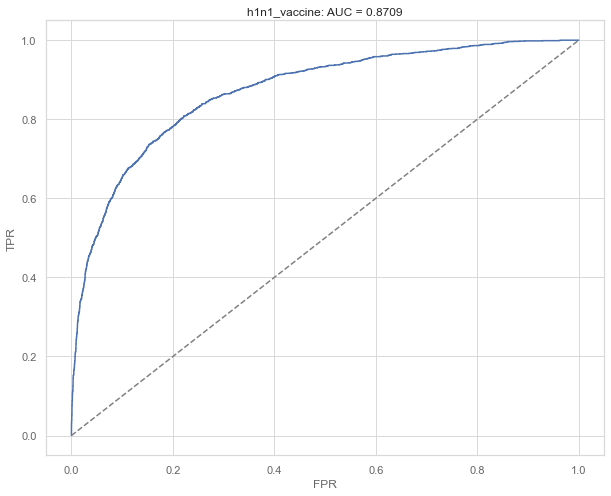

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['h1n1_vaccine'], 
    predictions_h1, 
    'h1n1_vaccine',
    ax=ax
)

In [152]:
roc_auc_score(y_test.h1n1_vaccine, predictions_h1)

0.8709112999023308

Seasonal vaccine

In [35]:
def objective(trial):
    param = {
        'iterations':trial.suggest_categorical('iterations', [100,200,300,500,700,1000,1200,1300,1500]),
        'learning_rate':trial.suggest_float("learning_rate", 0.001, 0.3),
        'random_strength':trial.suggest_int("random_strength", 1,10),
        'bagging_temperature':trial.suggest_int("bagging_temperature", 0,10),
        'max_bin':trial.suggest_categorical('max_bin', [4,5,6,8,10,20,30]),
        'grow_policy':trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf':trial.suggest_int("min_data_in_leaf", 1,10,20),
        'od_type' : "Iter",
        'od_wait' : 100,
        "depth": trial.suggest_int("max_depth", 2,10,15),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-8, 100),
         'one_hot_max_size':trial.suggest_categorical('one_hot_max_size', [5,10,12,100,500,1024]),
        'custom_metric' : ['AUC'],
        "loss_function": "Logloss",
        'auto_class_weights':trial.suggest_categorical('auto_class_weights', ['Balanced', 'SqrtBalanced']),
        }

    scores = cv(train_dataset_se,
            param,
            fold_count=5, 
            early_stopping_rounds=10,         
            plot=False, verbose=False)

    return scores['test-AUC-mean'].max()

In [36]:
sampler = optuna.samplers.TPESampler(seed=68)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2022-07-18 14:00:10,722] A new study created in memory with name: no-name-18ea3187-4d9e-48e7-8f28-09274f5238da
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(


Training on fold [0/5]

bestTest = 0.4739367219
bestIteration = 97

Training on fold [1/5]

bestTest = 0.4694872435
bestIteration = 106

Training on fold [2/5]

bestTest = 0.4541477895
bestIteration = 156

Training on fold [3/5]

bestTest = 0.4729716091
bestIteration = 87

Training on fold [4/5]


[I 2022-07-18 14:00:12,772] Trial 0 finished with value: 0.8596260041252229 and parameters: {'iterations': 1200, 'learning_rate': 0.27993591089710923, 'random_strength': 9, 'bagging_temperature': 8, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.001991194871120998, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.8596260041252229.



bestTest = 0.4701282291
bestIteration = 148

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.470860599
bestIteration = 282

Training on fold [1/5]

bestTest = 0.4700003229
bestIteration = 218

Training on fold [2/5]

bestTest = 0.4556673907
bestIteration = 317

Training on fold [3/5]

bestTest = 0.4715416329
bestIteration = 295

Training on fold [4/5]


[I 2022-07-18 14:00:16,569] Trial 1 finished with value: 0.8601976788175684 and parameters: {'iterations': 1500, 'learning_rate': 0.10842629332974436, 'random_strength': 4, 'bagging_temperature': 1, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.028402775147703313, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 1 with value: 0.8601976788175684.



bestTest = 0.4724234938
bestIteration = 173

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4715949868
bestIteration = 86

Training on fold [1/5]

bestTest = 0.4678039715
bestIteration = 136

Training on fold [2/5]

bestTest = 0.456334739
bestIteration = 114

Training on fold [3/5]

bestTest = 0.469680137
bestIteration = 129

Training on fold [4/5]


[I 2022-07-18 14:00:24,958] Trial 2 finished with value: 0.8602693845781241 and parameters: {'iterations': 200, 'learning_rate': 0.23559884921762703, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.027330135035255495, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.8602693845781241.



bestTest = 0.4719279036
bestIteration = 86

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4689248552
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4697599548
bestIteration = 134

Training on fold [2/5]

bestTest = 0.4590840023
bestIteration = 136

Training on fold [3/5]

bestTest = 0.4747227595
bestIteration = 110

Training on fold [4/5]


[I 2022-07-18 14:00:38,428] Trial 3 finished with value: 0.8601435093247645 and parameters: {'iterations': 1000, 'learning_rate': 0.194974145539544, 'random_strength': 10, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 1.300471404766049e-07, 'one_hot_max_size': 10, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.8602693845781241.



bestTest = 0.4667921991
bestIteration = 208

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4728468225
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4702530228
bestIteration = 298

Training on fold [2/5]

bestTest = 0.459259524
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4742725327
bestIteration = 299

Training on fold [4/5]


[I 2022-07-18 14:00:42,469] Trial 4 finished with value: 0.8594492011267933 and parameters: {'iterations': 300, 'learning_rate': 0.06928147101485782, 'random_strength': 6, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.00010293033487726667, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 2 with value: 0.8602693845781241.



bestTest = 0.4695508439
bestIteration = 299

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4775528121
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4745679724
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4634212722
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4775326683
bestIteration = 99

Training on fold [4/5]


[I 2022-07-18 14:00:44,381] Trial 5 finished with value: 0.8572768720002966 and parameters: {'iterations': 100, 'learning_rate': 0.1307813521062255, 'random_strength': 2, 'bagging_temperature': 3, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 13.751833235431702, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.8602693845781241.



bestTest = 0.4761438409
bestIteration = 99

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4698358097
bestIteration = 304

Training on fold [1/5]

bestTest = 0.4670777093
bestIteration = 548

Training on fold [2/5]

bestTest = 0.4571227798
bestIteration = 512

Training on fold [3/5]

bestTest = 0.4712030821
bestIteration = 430

Training on fold [4/5]


[I 2022-07-18 14:01:34,529] Trial 6 finished with value: 0.8607911761650249 and parameters: {'iterations': 1500, 'learning_rate': 0.05805171287971286, 'random_strength': 4, 'bagging_temperature': 8, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 2.6558249848041764, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 6 with value: 0.8607911761650249.



bestTest = 0.4675487535
bestIteration = 504

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4712469457
bestIteration = 207

Training on fold [1/5]

bestTest = 0.4683739162
bestIteration = 159

Training on fold [2/5]

bestTest = 0.4562414514
bestIteration = 218

Training on fold [3/5]

bestTest = 0.4713048568
bestIteration = 172

Training on fold [4/5]


[I 2022-07-18 14:01:37,872] Trial 7 finished with value: 0.8606107661440546 and parameters: {'iterations': 1300, 'learning_rate': 0.1807096213514747, 'random_strength': 4, 'bagging_temperature': 3, 'max_bin': 30, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 4.9369231964322795, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8607911761650249.



bestTest = 0.4700534149
bestIteration = 150

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4758171375
bestIteration = 1199

Training on fold [1/5]

bestTest = 0.4734553402
bestIteration = 1199

Training on fold [2/5]

bestTest = 0.4639089946
bestIteration = 1199

Training on fold [3/5]

bestTest = 0.4765356429
bestIteration = 1199

Training on fold [4/5]


[I 2022-07-18 14:01:52,849] Trial 8 finished with value: 0.8580958859270602 and parameters: {'iterations': 1200, 'learning_rate': 0.01226996693484591, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 9.501510078266123e-06, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 6 with value: 0.8607911761650249.



bestTest = 0.4735660549
bestIteration = 1198

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.6041808639
bestIteration = 99

Training on fold [1/5]

bestTest = 0.6025927147
bestIteration = 99

Training on fold [2/5]

bestTest = 0.5995718715
bestIteration = 99

Training on fold [3/5]

bestTest = 0.6029925511
bestIteration = 99

Training on fold [4/5]


[I 2022-07-18 14:02:00,592] Trial 9 finished with value: 0.8254342283172675 and parameters: {'iterations': 100, 'learning_rate': 0.007429919004710596, 'random_strength': 8, 'bagging_temperature': 2, 'max_bin': 4, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 1.1694576328936887e-07, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 6 with value: 0.8607911761650249.



bestTest = 0.6031677942
bestIteration = 99

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4701433296
bestIteration = 357

Training on fold [1/5]

bestTest = 0.4717803254
bestIteration = 334

Training on fold [2/5]

bestTest = 0.4567437268
bestIteration = 408

Training on fold [3/5]

bestTest = 0.4733717228
bestIteration = 424

Training on fold [4/5]


[I 2022-07-18 14:02:37,969] Trial 10 finished with value: 0.8601804720581316 and parameters: {'iterations': 500, 'learning_rate': 0.07030691356337633, 'random_strength': 7, 'bagging_temperature': 10, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 67.55513953843523, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8607911761650249.



bestTest = 0.4691982773
bestIteration = 363

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.471233444
bestIteration = 168

Training on fold [1/5]

bestTest = 0.4665202622
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4567816516
bestIteration = 128

Training on fold [3/5]

bestTest = 0.472732434
bestIteration = 145

Training on fold [4/5]


[I 2022-07-18 14:02:40,904] Trial 11 finished with value: 0.8601296553678524 and parameters: {'iterations': 1300, 'learning_rate': 0.19712053324255274, 'random_strength': 4, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 1.132726121845205, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 6 with value: 0.8607911761650249.



bestTest = 0.4710743368
bestIteration = 110

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4698299451
bestIteration = 134

Training on fold [1/5]

bestTest = 0.4681959356
bestIteration = 167

Training on fold [2/5]

bestTest = 0.4562953746
bestIteration = 155

Training on fold [3/5]

bestTest = 0.4678185411
bestIteration = 193

Training on fold [4/5]


[I 2022-07-18 14:02:44,069] Trial 12 finished with value: 0.8610482464824102 and parameters: {'iterations': 1500, 'learning_rate': 0.17249264359119662, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.6475340333678979, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 12 with value: 0.8610482464824102.



bestTest = 0.4686871391
bestIteration = 175

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4683323786
bestIteration = 360

Training on fold [1/5]

bestTest = 0.4662114997
bestIteration = 470

Training on fold [2/5]

bestTest = 0.4568594309
bestIteration = 316

Training on fold [3/5]

bestTest = 0.4718751285
bestIteration = 227

Training on fold [4/5]


[I 2022-07-18 14:03:21,319] Trial 13 finished with value: 0.8613903118136623 and parameters: {'iterations': 1500, 'learning_rate': 0.08079637756527824, 'random_strength': 1, 'bagging_temperature': 6, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.22569618537476618, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4666646147
bestIteration = 455

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4685025964
bestIteration = 196

Training on fold [1/5]

bestTest = 0.4686674126
bestIteration = 170

Training on fold [2/5]

bestTest = 0.4564828388
bestIteration = 197

Training on fold [3/5]

bestTest = 0.4705319122
bestIteration = 150

Training on fold [4/5]


[I 2022-07-18 14:03:24,303] Trial 14 finished with value: 0.8609574366178728 and parameters: {'iterations': 1500, 'learning_rate': 0.15343565009634413, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.15626248462692469, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4669291647
bestIteration = 265

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.469506481
bestIteration = 197

Training on fold [1/5]

bestTest = 0.4695810171
bestIteration = 173

Training on fold [2/5]

bestTest = 0.4582894306
bestIteration = 193

Training on fold [3/5]

bestTest = 0.4700186619
bestIteration = 257

Training on fold [4/5]


[I 2022-07-18 14:03:47,175] Trial 15 finished with value: 0.8606145869383817 and parameters: {'iterations': 700, 'learning_rate': 0.11471686732785508, 'random_strength': 1, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0025351879530061488, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.468509598
bestIteration = 235

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4692752153
bestIteration = 107

Training on fold [1/5]

bestTest = 0.4696829236
bestIteration = 78

Training on fold [2/5]

bestTest = 0.4557528201
bestIteration = 147

Training on fold [3/5]

bestTest = 0.4705935591
bestIteration = 134

Training on fold [4/5]


[I 2022-07-18 14:04:00,963] Trial 16 finished with value: 0.860910718532601 and parameters: {'iterations': 1500, 'learning_rate': 0.249179437332349, 'random_strength': 2, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.14255935614818757, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4660091393
bestIteration = 149

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4714963338
bestIteration = 142

Training on fold [1/5]

bestTest = 0.4710627696
bestIteration = 119

Training on fold [2/5]

bestTest = 0.457444523
bestIteration = 149

Training on fold [3/5]

bestTest = 0.4724484777
bestIteration = 129

Training on fold [4/5]


[I 2022-07-18 14:04:03,325] Trial 17 finished with value: 0.8601097389410075 and parameters: {'iterations': 1500, 'learning_rate': 0.16148765759383024, 'random_strength': 3, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 3.851796313982801e-05, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4675522121
bestIteration = 176

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4671414906
bestIteration = 336

Training on fold [1/5]

bestTest = 0.4691596003
bestIteration = 287

Training on fold [2/5]

bestTest = 0.4574831669
bestIteration = 339

Training on fold [3/5]

bestTest = 0.4710702729
bestIteration = 280

Training on fold [4/5]


[I 2022-07-18 14:04:35,167] Trial 18 finished with value: 0.8610195124573929 and parameters: {'iterations': 700, 'learning_rate': 0.08240949939823293, 'random_strength': 1, 'bagging_temperature': 4, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.30933125562324615, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4672401799
bestIteration = 352

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4713844996
bestIteration = 499

Training on fold [1/5]

bestTest = 0.4707455727
bestIteration = 499

Training on fold [2/5]

bestTest = 0.459437632
bestIteration = 498

Training on fold [3/5]

bestTest = 0.4734529013
bestIteration = 499

Training on fold [4/5]


[I 2022-07-18 14:05:31,648] Trial 19 finished with value: 0.8598399444213207 and parameters: {'iterations': 500, 'learning_rate': 0.039709031242663353, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 56.09939037666618, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4696568134
bestIteration = 499

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4691153898
bestIteration = 287

Training on fold [1/5]

bestTest = 0.4676459164
bestIteration = 279

Training on fold [2/5]

bestTest = 0.4568888771
bestIteration = 298

Training on fold [3/5]

bestTest = 0.471906831
bestIteration = 265

Training on fold [4/5]


[I 2022-07-18 14:05:35,902] Trial 20 finished with value: 0.8606739705305284 and parameters: {'iterations': 300, 'learning_rate': 0.10318197926662598, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.005810919787260997, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4698750173
bestIteration = 223

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4674744581
bestIteration = 378

Training on fold [1/5]

bestTest = 0.4690560668
bestIteration = 271

Training on fold [2/5]

bestTest = 0.4583472892
bestIteration = 265

Training on fold [3/5]

bestTest = 0.4701896884
bestIteration = 300

Training on fold [4/5]


[I 2022-07-18 14:06:07,047] Trial 21 finished with value: 0.8610643959300974 and parameters: {'iterations': 700, 'learning_rate': 0.0877160229902641, 'random_strength': 1, 'bagging_temperature': 4, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.4195020653794389, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4670243647
bestIteration = 304

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.469734513
bestIteration = 142

Training on fold [1/5]

bestTest = 0.4674243448
bestIteration = 261

Training on fold [2/5]

bestTest = 0.4565749471
bestIteration = 174

Training on fold [3/5]

bestTest = 0.4719205571
bestIteration = 164

Training on fold [4/5]


[I 2022-07-18 14:06:27,207] Trial 22 finished with value: 0.8609563184600756 and parameters: {'iterations': 700, 'learning_rate': 0.13398386652174976, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.6893108847622827, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4673776838
bestIteration = 214

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4684267454
bestIteration = 341

Training on fold [1/5]

bestTest = 0.4689192328
bestIteration = 268

Training on fold [2/5]

bestTest = 0.45865713
bestIteration = 271

Training on fold [3/5]

bestTest = 0.4702388726
bestIteration = 364

Training on fold [4/5]


[I 2022-07-18 14:07:00,051] Trial 23 finished with value: 0.860917868588418 and parameters: {'iterations': 1000, 'learning_rate': 0.09249931467876643, 'random_strength': 2, 'bagging_temperature': 3, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.027640923568100863, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4665842722
bestIteration = 352

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4834119894
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4823540413
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4727869754
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4834590935
bestIteration = 199

Training on fold [4/5]


[I 2022-07-18 14:07:19,694] Trial 24 finished with value: 0.8548113208389939 and parameters: {'iterations': 200, 'learning_rate': 0.03750663188236397, 'random_strength': 1, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.00022289973001291444, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4819298462
bestIteration = 199

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4691623195
bestIteration = 205

Training on fold [1/5]

bestTest = 0.4707520446
bestIteration = 143

Training on fold [2/5]

bestTest = 0.4570159637
bestIteration = 169

Training on fold [3/5]

bestTest = 0.4714187856
bestIteration = 215

Training on fold [4/5]


[I 2022-07-18 14:07:39,449] Trial 25 finished with value: 0.8604587045912794 and parameters: {'iterations': 700, 'learning_rate': 0.13646097396846005, 'random_strength': 2, 'bagging_temperature': 2, 'max_bin': 8, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 9.322868427147666, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.46831175
bestIteration = 182

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4706540249
bestIteration = 94

Training on fold [1/5]

bestTest = 0.4672496233
bestIteration = 164

Training on fold [2/5]

bestTest = 0.4598539589
bestIteration = 120

Training on fold [3/5]

bestTest = 0.4723255293
bestIteration = 144

Training on fold [4/5]


[I 2022-07-18 14:07:54,035] Trial 26 finished with value: 0.8604033971549592 and parameters: {'iterations': 1500, 'learning_rate': 0.21366180952271552, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 1.0595003544247859e-08, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4645030248
bestIteration = 159

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4714487309
bestIteration = 147

Training on fold [1/5]

bestTest = 0.4675412902
bestIteration = 162

Training on fold [2/5]

bestTest = 0.4561783277
bestIteration = 177

Training on fold [3/5]

bestTest = 0.4738136646
bestIteration = 197

Training on fold [4/5]


[I 2022-07-18 14:07:57,164] Trial 27 finished with value: 0.8603646559898783 and parameters: {'iterations': 1500, 'learning_rate': 0.17002865016407984, 'random_strength': 5, 'bagging_temperature': 5, 'max_bin': 4, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.05683854155475645, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4681336524
bestIteration = 163

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4698711295
bestIteration = 545

Training on fold [1/5]

bestTest = 0.4690353845
bestIteration = 484

Training on fold [2/5]

bestTest = 0.4564758044
bestIteration = 603

Training on fold [3/5]

bestTest = 0.470740498
bestIteration = 564

Training on fold [4/5]


[I 2022-07-18 14:08:05,494] Trial 28 finished with value: 0.8610237520935474 and parameters: {'iterations': 700, 'learning_rate': 0.041805281975713066, 'random_strength': 1, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.00945203087407442, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4678540273
bestIteration = 551

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4723514262
bestIteration = 100

Training on fold [1/5]

bestTest = 0.4702224936
bestIteration = 99

Training on fold [2/5]

bestTest = 0.456808306
bestIteration = 117

Training on fold [3/5]

bestTest = 0.4732086451
bestIteration = 85

Training on fold [4/5]


[I 2022-07-18 14:08:07,323] Trial 29 finished with value: 0.8594969122367722 and parameters: {'iterations': 1200, 'learning_rate': 0.2835047190717169, 'random_strength': 9, 'bagging_temperature': 2, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0005950206532270878, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4718804244
bestIteration = 106

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4702376608
bestIteration = 282

Training on fold [1/5]

bestTest = 0.4708548016
bestIteration = 236

Training on fold [2/5]

bestTest = 0.4569584743
bestIteration = 242

Training on fold [3/5]

bestTest = 0.4719169196
bestIteration = 236

Training on fold [4/5]


[I 2022-07-18 14:08:31,899] Trial 30 finished with value: 0.8605129088579802 and parameters: {'iterations': 1500, 'learning_rate': 0.11816987809671578, 'random_strength': 6, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 1.192289660084317, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4666702529
bestIteration = 274

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4716292383
bestIteration = 387

Training on fold [1/5]

bestTest = 0.4657808122
bestIteration = 672

Training on fold [2/5]

bestTest = 0.4555818231
bestIteration = 551

Training on fold [3/5]

bestTest = 0.4702907992
bestIteration = 578

Training on fold [4/5]


[I 2022-07-18 14:08:39,012] Trial 31 finished with value: 0.8613658860130851 and parameters: {'iterations': 700, 'learning_rate': 0.0452053119133547, 'random_strength': 1, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.009499505638257045, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4682254708
bestIteration = 505

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4711914076
bestIteration = 699

Training on fold [1/5]

bestTest = 0.4707600995
bestIteration = 696

Training on fold [2/5]

bestTest = 0.459333276
bestIteration = 699

Training on fold [3/5]

bestTest = 0.4727384336
bestIteration = 699

Training on fold [4/5]


[I 2022-07-18 14:08:47,630] Trial 32 finished with value: 0.8600466442362349 and parameters: {'iterations': 700, 'learning_rate': 0.026879985732241023, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.24050890077225745, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4705425409
bestIteration = 653

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4700544838
bestIteration = 403

Training on fold [1/5]

bestTest = 0.4691002949
bestIteration = 353

Training on fold [2/5]

bestTest = 0.4563045702
bestIteration = 442

Training on fold [3/5]

bestTest = 0.4708497598
bestIteration = 428

Training on fold [4/5]


[I 2022-07-18 14:08:52,924] Trial 33 finished with value: 0.8608498506476018 and parameters: {'iterations': 700, 'learning_rate': 0.057473100017839604, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0013661941468324015, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4690985666
bestIteration = 363

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4707628282
bestIteration = 234

Training on fold [1/5]

bestTest = 0.4675619171
bestIteration = 364

Training on fold [2/5]

bestTest = 0.457938919
bestIteration = 282

Training on fold [3/5]

bestTest = 0.4704679734
bestIteration = 323

Training on fold [4/5]


[I 2022-07-18 14:08:56,740] Trial 34 finished with value: 0.8603791380110126 and parameters: {'iterations': 1000, 'learning_rate': 0.08724194509231108, 'random_strength': 2, 'bagging_temperature': 6, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.01128376843401292, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4702091313
bestIteration = 291

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4709382577
bestIteration = 129

Training on fold [1/5]

bestTest = 0.4700729996
bestIteration = 109

Training on fold [2/5]

bestTest = 0.4574187293
bestIteration = 109

Training on fold [3/5]

bestTest = 0.4719818468
bestIteration = 137

Training on fold [4/5]


[I 2022-07-18 14:08:58,465] Trial 35 finished with value: 0.8599763744291755 and parameters: {'iterations': 200, 'learning_rate': 0.2283575300177211, 'random_strength': 3, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.05857631444435135, 'one_hot_max_size': 500, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4690672088
bestIteration = 148

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4731600873
bestIteration = 70

Training on fold [1/5]

bestTest = 0.4707327392
bestIteration = 76

Training on fold [2/5]

bestTest = 0.4565998869
bestIteration = 82

Training on fold [3/5]

bestTest = 0.4694138396
bestIteration = 143

Training on fold [4/5]


[I 2022-07-18 14:09:06,436] Trial 36 finished with value: 0.8603014566656366 and parameters: {'iterations': 300, 'learning_rate': 0.26062568346210263, 'random_strength': 1, 'bagging_temperature': 4, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 20.915002072424137, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4677588723
bestIteration = 103

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4942271845
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4904147299
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4813622307
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4913985019
bestIteration = 99

Training on fold [4/5]


[I 2022-07-18 14:09:13,582] Trial 37 finished with value: 0.8504921170288865 and parameters: {'iterations': 100, 'learning_rate': 0.06730405543312588, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 2.236651740548096, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4897422201
bestIteration = 99

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4686259182
bestIteration = 306

Training on fold [1/5]

bestTest = 0.4688563015
bestIteration = 303

Training on fold [2/5]

bestTest = 0.4568192061
bestIteration = 323

Training on fold [3/5]

bestTest = 0.4738023173
bestIteration = 255

Training on fold [4/5]


[I 2022-07-18 14:09:17,515] Trial 38 finished with value: 0.8607219041471262 and parameters: {'iterations': 1500, 'learning_rate': 0.10257075422861325, 'random_strength': 10, 'bagging_temperature': 3, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.053880027741329176, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4665462976
bestIteration = 343

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4703860194
bestIteration = 915

Training on fold [1/5]

bestTest = 0.4694244144
bestIteration = 918

Training on fold [2/5]

bestTest = 0.4574273371
bestIteration = 920

Training on fold [3/5]

bestTest = 0.4702445267
bestIteration = 1027

Training on fold [4/5]


[I 2022-07-18 14:09:29,969] Trial 39 finished with value: 0.8605498539397072 and parameters: {'iterations': 1300, 'learning_rate': 0.022505578944538793, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.3272521186360546, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4724316894
bestIteration = 638

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4703395261
bestIteration = 520

Training on fold [1/5]

bestTest = 0.4679712902
bestIteration = 586

Training on fold [2/5]

bestTest = 0.4570744207
bestIteration = 562

Training on fold [3/5]

bestTest = 0.4715844473
bestIteration = 553

Training on fold [4/5]


[I 2022-07-18 14:09:37,290] Trial 40 finished with value: 0.8604125536083791 and parameters: {'iterations': 1200, 'learning_rate': 0.054390371402494454, 'random_strength': 4, 'bagging_temperature': 5, 'max_bin': 10, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 3.690816159194805e-06, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4721135179
bestIteration = 386

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4686731744
bestIteration = 667

Training on fold [1/5]

bestTest = 0.4678082387
bestIteration = 569

Training on fold [2/5]

bestTest = 0.4571772406
bestIteration = 511

Training on fold [3/5]

bestTest = 0.470580305
bestIteration = 525

Training on fold [4/5]


[I 2022-07-18 14:09:44,865] Trial 41 finished with value: 0.861298386140468 and parameters: {'iterations': 700, 'learning_rate': 0.0444556852594834, 'random_strength': 1, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0076749389153512974, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 13 with value: 0.8613903118136623.



bestTest = 0.4670589825
bestIteration = 603

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4693419168
bestIteration = 331

Training on fold [1/5]

bestTest = 0.4672095254
bestIteration = 362

Training on fold [2/5]

bestTest = 0.4566732797
bestIteration = 333

Training on fold [3/5]

bestTest = 0.469673143
bestIteration = 364

Training on fold [4/5]


[I 2022-07-18 14:09:49,744] Trial 42 finished with value: 0.8615391449194707 and parameters: {'iterations': 700, 'learning_rate': 0.0824778149250548, 'random_strength': 2, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.004374663631521421, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4654938129
bestIteration = 410

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.470674082
bestIteration = 293

Training on fold [1/5]

bestTest = 0.4669297287
bestIteration = 365

Training on fold [2/5]

bestTest = 0.4580942656
bestIteration = 287

Training on fold [3/5]

bestTest = 0.4725775378
bestIteration = 251

Training on fold [4/5]


[I 2022-07-18 14:09:54,582] Trial 43 finished with value: 0.8606576500587947 and parameters: {'iterations': 700, 'learning_rate': 0.07679922284115177, 'random_strength': 2, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.005035564188511646, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4679230477
bestIteration = 309

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.523679464
bestIteration = 699

Training on fold [1/5]

bestTest = 0.5224657631
bestIteration = 699

Training on fold [2/5]

bestTest = 0.5180183783
bestIteration = 699

Training on fold [3/5]

bestTest = 0.522760257
bestIteration = 699

Training on fold [4/5]


[I 2022-07-18 14:10:46,430] Trial 44 finished with value: 0.838076170748767 and parameters: {'iterations': 700, 'learning_rate': 0.003499200283026374, 'random_strength': 2, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.01745378690043205, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.521278891
bestIteration = 699

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4699177122
bestIteration = 468

Training on fold [1/5]

bestTest = 0.4675532784
bestIteration = 582

Training on fold [2/5]

bestTest = 0.4560625116
bestIteration = 503

Training on fold [3/5]

bestTest = 0.4727275983
bestIteration = 384

Training on fold [4/5]


[I 2022-07-18 14:10:52,502] Trial 45 finished with value: 0.8608868525222821 and parameters: {'iterations': 700, 'learning_rate': 0.04775518900946249, 'random_strength': 1, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.00038567933084196785, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4686023494
bestIteration = 489

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4700822836
bestIteration = 699

Training on fold [1/5]

bestTest = 0.4703854545
bestIteration = 699

Training on fold [2/5]

bestTest = 0.4582542564
bestIteration = 699

Training on fold [3/5]

bestTest = 0.4722595818
bestIteration = 695

Training on fold [4/5]


[I 2022-07-18 14:11:41,715] Trial 46 finished with value: 0.8599647320226232 and parameters: {'iterations': 700, 'learning_rate': 0.025866840573709124, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0022771237219367385, 'one_hot_max_size': 12, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.470752658
bestIteration = 624

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4702912434
bestIteration = 357

Training on fold [1/5]

bestTest = 0.4684167379
bestIteration = 436

Training on fold [2/5]

bestTest = 0.4554321365
bestIteration = 451

Training on fold [3/5]

bestTest = 0.4724209242
bestIteration = 355

Training on fold [4/5]


[I 2022-07-18 14:11:47,543] Trial 47 finished with value: 0.8605577975252633 and parameters: {'iterations': 500, 'learning_rate': 0.06219590316181042, 'random_strength': 3, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 4.6791208152656054e-05, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4709076807
bestIteration = 326

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4678516522
bestIteration = 260

Training on fold [1/5]

bestTest = 0.4657909781
bestIteration = 350

Training on fold [2/5]

bestTest = 0.4576009183
bestIteration = 181

Training on fold [3/5]

bestTest = 0.4712526615
bestIteration = 172

Training on fold [4/5]


[I 2022-07-18 14:12:06,260] Trial 48 finished with value: 0.8613239586855664 and parameters: {'iterations': 700, 'learning_rate': 0.12129813899778985, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.10746151657274071, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4669860857
bestIteration = 222

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4834106553
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4826060071
bestIteration = 99

Training on fold [2/5]

bestTest = 0.4744323508
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4846624086
bestIteration = 99

Training on fold [4/5]


[I 2022-07-18 14:12:07,719] Trial 49 finished with value: 0.8540672188029177 and parameters: {'iterations': 100, 'learning_rate': 0.1158405412761714, 'random_strength': 8, 'bagging_temperature': 10, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.07697897170526383, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4818211839
bestIteration = 99

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4714348041
bestIteration = 148

Training on fold [1/5]

bestTest = 0.4691045892
bestIteration = 161

Training on fold [2/5]

bestTest = 0.4568000009
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4718526803
bestIteration = 165

Training on fold [4/5]


[I 2022-07-18 14:12:10,275] Trial 50 finished with value: 0.8601107901979299 and parameters: {'iterations': 700, 'learning_rate': 0.14724177748733366, 'random_strength': 2, 'bagging_temperature': 9, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0032864120382745205, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4685196391
bestIteration = 136

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4681766361
bestIteration = 248

Training on fold [1/5]

bestTest = 0.4690325063
bestIteration = 207

Training on fold [2/5]

bestTest = 0.4568403868
bestIteration = 270

Training on fold [3/5]

bestTest = 0.4718437898
bestIteration = 218

Training on fold [4/5]


[I 2022-07-18 14:12:30,682] Trial 51 finished with value: 0.8609914809577347 and parameters: {'iterations': 700, 'learning_rate': 0.09516349720974585, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0247796794608712, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4672219478
bestIteration = 283

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4688531724
bestIteration = 318

Training on fold [1/5]

bestTest = 0.4702663409
bestIteration = 266

Training on fold [2/5]

bestTest = 0.4588231314
bestIteration = 253

Training on fold [3/5]

bestTest = 0.4698769466
bestIteration = 342

Training on fold [4/5]


[I 2022-07-18 14:12:55,158] Trial 52 finished with value: 0.8608822299431376 and parameters: {'iterations': 700, 'learning_rate': 0.07641578414119313, 'random_strength': 1, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.15346871352277563, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.466811708
bestIteration = 441

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4696156955
bestIteration = 201

Training on fold [1/5]

bestTest = 0.4690929652
bestIteration = 152

Training on fold [2/5]

bestTest = 0.4584591145
bestIteration = 178

Training on fold [3/5]

bestTest = 0.4684279581
bestIteration = 248

Training on fold [4/5]


[I 2022-07-18 14:13:10,894] Trial 53 finished with value: 0.8609461806945647 and parameters: {'iterations': 700, 'learning_rate': 0.12749209485271532, 'random_strength': 1, 'bagging_temperature': 7, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.011356268499991225, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4672683266
bestIteration = 245

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4699939548
bestIteration = 246

Training on fold [1/5]

bestTest = 0.4689282439
bestIteration = 276

Training on fold [2/5]

bestTest = 0.4581115751
bestIteration = 267

Training on fold [3/5]

bestTest = 0.4716076222
bestIteration = 253

Training on fold [4/5]


[I 2022-07-18 14:13:31,685] Trial 54 finished with value: 0.8605367895586991 and parameters: {'iterations': 1300, 'learning_rate': 0.08622759453431686, 'random_strength': 2, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.001040951136774639, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4680239661
bestIteration = 356

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.467690322
bestIteration = 279

Training on fold [1/5]

bestTest = 0.4676625317
bestIteration = 261

Training on fold [2/5]

bestTest = 0.4584354311
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4700913834
bestIteration = 225

Training on fold [4/5]


[I 2022-07-18 14:13:49,268] Trial 55 finished with value: 0.8610705430352616 and parameters: {'iterations': 700, 'learning_rate': 0.09763980666066914, 'random_strength': 1, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.44831769238043284, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4690793362
bestIteration = 192

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.469359784
bestIteration = 226

Training on fold [1/5]

bestTest = 0.4689137317
bestIteration = 189

Training on fold [2/5]

bestTest = 0.4577935698
bestIteration = 241

Training on fold [3/5]

bestTest = 0.4696408288
bestIteration = 303

Training on fold [4/5]


[I 2022-07-18 14:13:53,240] Trial 56 finished with value: 0.8610346414185898 and parameters: {'iterations': 700, 'learning_rate': 0.10695495109005941, 'random_strength': 1, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0001413183529048402, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4662716884
bestIteration = 291

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.470713631
bestIteration = 299

Training on fold [1/5]

bestTest = 0.4697149755
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4583554275
bestIteration = 299

Training on fold [3/5]

bestTest = 0.4725713064
bestIteration = 297

Training on fold [4/5]


[I 2022-07-18 14:14:15,787] Trial 57 finished with value: 0.859982328739385 and parameters: {'iterations': 300, 'learning_rate': 0.07291105171137455, 'random_strength': 3, 'bagging_temperature': 7, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 2.7471823475991064, 'one_hot_max_size': 5, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4688222996
bestIteration = 295

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.5180850359
bestIteration = 199

Training on fold [1/5]

bestTest = 0.5164590969
bestIteration = 199

Training on fold [2/5]

bestTest = 0.5116506659
bestIteration = 199

Training on fold [3/5]

bestTest = 0.5171794103
bestIteration = 199

Training on fold [4/5]


[I 2022-07-18 14:14:31,920] Trial 58 finished with value: 0.8399838391871046 and parameters: {'iterations': 200, 'learning_rate': 0.013851803019486658, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.09528763220504603, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.5164105371
bestIteration = 199

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4702003455
bestIteration = 277

Training on fold [1/5]

bestTest = 0.4699962392
bestIteration = 229

Training on fold [2/5]

bestTest = 0.4574363394
bestIteration = 207

Training on fold [3/5]

bestTest = 0.4711568376
bestIteration = 277

Training on fold [4/5]


[I 2022-07-18 14:14:53,303] Trial 59 finished with value: 0.8608031262428112 and parameters: {'iterations': 1000, 'learning_rate': 0.12435107594551764, 'random_strength': 7, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.9266060494607489, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4652933845
bestIteration = 348

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.468954917
bestIteration = 525

Training on fold [1/5]

bestTest = 0.4675761858
bestIteration = 504

Training on fold [2/5]

bestTest = 0.4569168884
bestIteration = 514

Training on fold [3/5]

bestTest = 0.4706560086
bestIteration = 542

Training on fold [4/5]


[I 2022-07-18 14:15:00,525] Trial 60 finished with value: 0.8609176850576796 and parameters: {'iterations': 700, 'learning_rate': 0.05038383890228263, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.029532049620247046, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4700726233
bestIteration = 395

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4689041289
bestIteration = 372

Training on fold [1/5]

bestTest = 0.4692995875
bestIteration = 375

Training on fold [2/5]

bestTest = 0.458156018
bestIteration = 315

Training on fold [3/5]

bestTest = 0.4714000094
bestIteration = 373

Training on fold [4/5]


[I 2022-07-18 14:15:28,331] Trial 61 finished with value: 0.8606518809336476 and parameters: {'iterations': 700, 'learning_rate': 0.09398784228893296, 'random_strength': 1, 'bagging_temperature': 4, 'max_bin': 20, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.5318502630607093, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4689104013
bestIteration = 319

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4691336497
bestIteration = 315

Training on fold [1/5]

bestTest = 0.468367624
bestIteration = 410

Training on fold [2/5]

bestTest = 0.4574947411
bestIteration = 349

Training on fold [3/5]

bestTest = 0.4713053045
bestIteration = 381

Training on fold [4/5]


[I 2022-07-18 14:15:57,063] Trial 62 finished with value: 0.8608101893473427 and parameters: {'iterations': 700, 'learning_rate': 0.06700888717844071, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 8, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 4.423343891612788, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4685139938
bestIteration = 344

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4677035209
bestIteration = 177

Training on fold [1/5]

bestTest = 0.4674306462
bestIteration = 221

Training on fold [2/5]

bestTest = 0.4580548351
bestIteration = 159

Training on fold [3/5]

bestTest = 0.4707021434
bestIteration = 192

Training on fold [4/5]


[I 2022-07-18 14:16:18,350] Trial 63 finished with value: 0.8610035629844276 and parameters: {'iterations': 700, 'learning_rate': 0.13906971218506758, 'random_strength': 1, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.3403896394568254, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4682184806
bestIteration = 211

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4708185525
bestIteration = 495

Training on fold [1/5]

bestTest = 0.4704590395
bestIteration = 499

Training on fold [2/5]

bestTest = 0.4591324851
bestIteration = 499

Training on fold [3/5]

bestTest = 0.4730034291
bestIteration = 498

Training on fold [4/5]


[I 2022-07-18 14:16:57,730] Trial 64 finished with value: 0.8602196392778941 and parameters: {'iterations': 500, 'learning_rate': 0.036247279010395074, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0065302649093433186, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4695170484
bestIteration = 499

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.466864729
bestIteration = 359

Training on fold [1/5]

bestTest = 0.4678829977
bestIteration = 236

Training on fold [2/5]

bestTest = 0.4561466075
bestIteration = 269

Training on fold [3/5]

bestTest = 0.4721426511
bestIteration = 176

Training on fold [4/5]


[I 2022-07-18 14:17:01,950] Trial 65 finished with value: 0.8611471344290695 and parameters: {'iterations': 700, 'learning_rate': 0.10041617446733511, 'random_strength': 1, 'bagging_temperature': 3, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.024117681854798026, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4696184546
bestIteration = 180

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4700203086
bestIteration = 223

Training on fold [1/5]

bestTest = 0.4672760213
bestIteration = 225

Training on fold [2/5]

bestTest = 0.4545183847
bestIteration = 279

Training on fold [3/5]

bestTest = 0.4704162111
bestIteration = 259

Training on fold [4/5]


[I 2022-07-18 14:17:06,573] Trial 66 finished with value: 0.8613201783890985 and parameters: {'iterations': 1200, 'learning_rate': 0.11045396792488635, 'random_strength': 2, 'bagging_temperature': 0, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.034394211946049656, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4687471317
bestIteration = 184

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4848566727
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4827318408
bestIteration = 99

Training on fold [2/5]

bestTest = 0.473226871
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4838782335
bestIteration = 99

Training on fold [4/5]


[I 2022-07-18 14:17:08,512] Trial 67 finished with value: 0.8540609336940201 and parameters: {'iterations': 100, 'learning_rate': 0.10683330694308216, 'random_strength': 4, 'bagging_temperature': 1, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0035765369505756568, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4804491363
bestIteration = 99

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4689167036
bestIteration = 214

Training on fold [1/5]

bestTest = 0.467844442
bestIteration = 178

Training on fold [2/5]

bestTest = 0.4565401443
bestIteration = 232

Training on fold [3/5]

bestTest = 0.4719480292
bestIteration = 172

Training on fold [4/5]


[I 2022-07-18 14:17:11,832] Trial 68 finished with value: 0.8609448821161587 and parameters: {'iterations': 1200, 'learning_rate': 0.1466202956984506, 'random_strength': 2, 'bagging_temperature': 0, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0005225756263223102, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4662256886
bestIteration = 271

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4697621306
bestIteration = 234

Training on fold [1/5]

bestTest = 0.4679270624
bestIteration = 215

Training on fold [2/5]

bestTest = 0.4567931383
bestIteration = 226

Training on fold [3/5]

bestTest = 0.4718431097
bestIteration = 209

Training on fold [4/5]


[I 2022-07-18 14:17:15,708] Trial 69 finished with value: 0.8610164231060138 and parameters: {'iterations': 1200, 'learning_rate': 0.11938055491224417, 'random_strength': 3, 'bagging_temperature': 1, 'max_bin': 5, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.04033524440094276, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4658173506
bestIteration = 338

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4695204006
bestIteration = 468

Training on fold [1/5]

bestTest = 0.468578503
bestIteration = 370

Training on fold [2/5]

bestTest = 0.4565795885
bestIteration = 370

Training on fold [3/5]

bestTest = 0.471628716
bestIteration = 381

Training on fold [4/5]


[I 2022-07-18 14:17:21,813] Trial 70 finished with value: 0.8608280602518146 and parameters: {'iterations': 1200, 'learning_rate': 0.07883775444921162, 'random_strength': 2, 'bagging_temperature': 2, 'max_bin': 6, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.01688429889615413, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4702892471
bestIteration = 348

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4697673217
bestIteration = 259

Training on fold [1/5]

bestTest = 0.4673743535
bestIteration = 239

Training on fold [2/5]

bestTest = 0.4571246634
bestIteration = 219

Training on fold [3/5]

bestTest = 0.4714435747
bestIteration = 214

Training on fold [4/5]


[I 2022-07-18 14:17:25,107] Trial 71 finished with value: 0.8609659683984354 and parameters: {'iterations': 700, 'learning_rate': 0.11142884338131119, 'random_strength': 1, 'bagging_temperature': 6, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.11261234491592013, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4677418639
bestIteration = 231

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.469113187
bestIteration = 246

Training on fold [1/5]

bestTest = 0.4692000588
bestIteration = 235

Training on fold [2/5]

bestTest = 0.4562114029
bestIteration = 298

Training on fold [3/5]

bestTest = 0.4702725455
bestIteration = 242

Training on fold [4/5]


[I 2022-07-18 14:17:28,484] Trial 72 finished with value: 0.8609811938398257 and parameters: {'iterations': 1500, 'learning_rate': 0.09750651593383658, 'random_strength': 1, 'bagging_temperature': 0, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.19279970606648517, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4677275833
bestIteration = 281

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4727378116
bestIteration = 187

Training on fold [1/5]

bestTest = 0.4710045758
bestIteration = 204

Training on fold [2/5]

bestTest = 0.4561780257
bestIteration = 295

Training on fold [3/5]

bestTest = 0.4718115459
bestIteration = 236

Training on fold [4/5]


[I 2022-07-18 14:17:31,465] Trial 73 finished with value: 0.8601752162036433 and parameters: {'iterations': 1200, 'learning_rate': 0.08298132701778843, 'random_strength': 1, 'bagging_temperature': 3, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0015157795104195778, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4699186896
bestIteration = 221

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4686092868
bestIteration = 398

Training on fold [1/5]

bestTest = 0.4692407821
bestIteration = 376

Training on fold [2/5]

bestTest = 0.4557351093
bestIteration = 427

Training on fold [3/5]

bestTest = 0.4710070202
bestIteration = 361

Training on fold [4/5]


[I 2022-07-18 14:18:00,764] Trial 74 finished with value: 0.860982721277456 and parameters: {'iterations': 700, 'learning_rate': 0.062195459100164135, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.007911578468604694, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4691614096
bestIteration = 317

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4698002261
bestIteration = 259

Training on fold [1/5]

bestTest = 0.4672462371
bestIteration = 294

Training on fold [2/5]

bestTest = 0.4575161896
bestIteration = 224

Training on fold [3/5]

bestTest = 0.4710127347
bestIteration = 195

Training on fold [4/5]


[I 2022-07-18 14:18:04,255] Trial 75 finished with value: 0.8610438199076093 and parameters: {'iterations': 700, 'learning_rate': 0.09892792298208544, 'random_strength': 1, 'bagging_temperature': 5, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.018630599564210502, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4678448478
bestIteration = 241

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4712052329
bestIteration = 129

Training on fold [1/5]

bestTest = 0.4675793947
bestIteration = 179

Training on fold [2/5]

bestTest = 0.4585927628
bestIteration = 132

Training on fold [3/5]

bestTest = 0.4697239819
bestIteration = 241

Training on fold [4/5]


[I 2022-07-18 14:18:07,003] Trial 76 finished with value: 0.8605551660246785 and parameters: {'iterations': 300, 'learning_rate': 0.159560622586292, 'random_strength': 2, 'bagging_temperature': 2, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.04800224224578195, 'one_hot_max_size': 1024, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4672521484
bestIteration = 185

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4709121519
bestIteration = 89

Training on fold [1/5]

bestTest = 0.470736682
bestIteration = 62

Training on fold [2/5]

bestTest = 0.4573887704
bestIteration = 105

Training on fold [3/5]

bestTest = 0.4717384227
bestIteration = 100

Training on fold [4/5]


[I 2022-07-18 14:18:08,764] Trial 77 finished with value: 0.8595939778294074 and parameters: {'iterations': 1300, 'learning_rate': 0.2949875854155578, 'random_strength': 1, 'bagging_temperature': 6, 'max_bin': 4, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 1.1241059582068307, 'one_hot_max_size': 100, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4706138811
bestIteration = 71

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.469051635
bestIteration = 580

Training on fold [1/5]

bestTest = 0.4677770322
bestIteration = 587

Training on fold [2/5]

bestTest = 0.455611409
bestIteration = 643

Training on fold [3/5]

bestTest = 0.470688203
bestIteration = 505

Training on fold [4/5]


[I 2022-07-18 14:18:16,630] Trial 78 finished with value: 0.8612632649016569 and parameters: {'iterations': 1000, 'learning_rate': 0.04503020489629817, 'random_strength': 1, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.11749549523759856, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4690030257
bestIteration = 455

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4698643637
bestIteration = 534

Training on fold [1/5]

bestTest = 0.4684671328
bestIteration = 603

Training on fold [2/5]

bestTest = 0.4575792022
bestIteration = 523

Training on fold [3/5]

bestTest = 0.4712908979
bestIteration = 550

Training on fold [4/5]


[I 2022-07-18 14:18:24,123] Trial 79 finished with value: 0.8606988369438409 and parameters: {'iterations': 1000, 'learning_rate': 0.045833056968558765, 'random_strength': 5, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.004696517808665219, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4700264933
bestIteration = 462

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4707763782
bestIteration = 649

Training on fold [1/5]

bestTest = 0.4675899554
bestIteration = 810

Training on fold [2/5]

bestTest = 0.4578940163
bestIteration = 639

Training on fold [3/5]

bestTest = 0.4705307766
bestIteration = 792

Training on fold [4/5]


[I 2022-07-18 14:18:33,644] Trial 80 finished with value: 0.860898381376014 and parameters: {'iterations': 1000, 'learning_rate': 0.033219388266173065, 'random_strength': 2, 'bagging_temperature': 1, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.08716635004167382, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.469131978
bestIteration = 622

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4715396276
bestIteration = 999

Training on fold [1/5]

bestTest = 0.4707461569
bestIteration = 999

Training on fold [2/5]

bestTest = 0.4596479045
bestIteration = 999

Training on fold [3/5]

bestTest = 0.4734437531
bestIteration = 997

Training on fold [4/5]


[I 2022-07-18 14:18:47,905] Trial 81 finished with value: 0.8599999838537947 and parameters: {'iterations': 1000, 'learning_rate': 0.016654115976124345, 'random_strength': 1, 'bagging_temperature': 0, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.21449408170770728, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.470788857
bestIteration = 999

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4688308957
bestIteration = 231

Training on fold [1/5]

bestTest = 0.4684822553
bestIteration = 255

Training on fold [2/5]

bestTest = 0.4569657289
bestIteration = 291

Training on fold [3/5]

bestTest = 0.4715336766
bestIteration = 215

Training on fold [4/5]


[I 2022-07-18 14:18:51,284] Trial 82 finished with value: 0.8607381017356509 and parameters: {'iterations': 1500, 'learning_rate': 0.09158049552722283, 'random_strength': 1, 'bagging_temperature': 3, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.011877655920000264, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4701252058
bestIteration = 196

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4790966352
bestIteration = 199

Training on fold [1/5]

bestTest = 0.4769265908
bestIteration = 199

Training on fold [2/5]

bestTest = 0.4667706801
bestIteration = 199

Training on fold [3/5]

bestTest = 0.4782136568
bestIteration = 199

Training on fold [4/5]


[I 2022-07-18 14:18:54,425] Trial 83 finished with value: 0.8568525961973039 and parameters: {'iterations': 200, 'learning_rate': 0.05840286137173833, 'random_strength': 2, 'bagging_temperature': 1, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.031486950105968685, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4750469058
bestIteration = 199

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4707179415
bestIteration = 160

Training on fold [1/5]

bestTest = 0.4678695986
bestIteration = 231

Training on fold [2/5]

bestTest = 0.456881011
bestIteration = 209

Training on fold [3/5]

bestTest = 0.4721799028
bestIteration = 187

Training on fold [4/5]


[I 2022-07-18 14:19:10,425] Trial 84 finished with value: 0.8608245261518894 and parameters: {'iterations': 700, 'learning_rate': 0.12995256581003028, 'random_strength': 1, 'bagging_temperature': 6, 'max_bin': 30, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.5281312556923614, 'one_hot_max_size': 12, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4657117643
bestIteration = 216

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4702999518
bestIteration = 293

Training on fold [1/5]

bestTest = 0.4667111189
bestIteration = 459

Training on fold [2/5]

bestTest = 0.4569038711
bestIteration = 294

Training on fold [3/5]

bestTest = 0.4693664341
bestIteration = 365

Training on fold [4/5]


[I 2022-07-18 14:19:15,785] Trial 85 finished with value: 0.8609843015542046 and parameters: {'iterations': 1000, 'learning_rate': 0.07234923504399964, 'random_strength': 1, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 2.162879798518231, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4714652626
bestIteration = 225

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4690218467
bestIteration = 251

Training on fold [1/5]

bestTest = 0.4675328089
bestIteration = 302

Training on fold [2/5]

bestTest = 0.456391496
bestIteration = 259

Training on fold [3/5]

bestTest = 0.4712165605
bestIteration = 170

Training on fold [4/5]


[I 2022-07-18 14:19:40,943] Trial 86 finished with value: 0.8609749138593334 and parameters: {'iterations': 700, 'learning_rate': 0.12274210704381361, 'random_strength': 1, 'bagging_temperature': 1, 'max_bin': 6, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.1268454815064228, 'one_hot_max_size': 10, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4681644159
bestIteration = 228

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4715864966
bestIteration = 234

Training on fold [1/5]

bestTest = 0.4680162356
bestIteration = 269

Training on fold [2/5]

bestTest = 0.4560512241
bestIteration = 330

Training on fold [3/5]

bestTest = 0.4719133103
bestIteration = 276

Training on fold [4/5]


[I 2022-07-18 14:19:45,064] Trial 87 finished with value: 0.8603363026910562 and parameters: {'iterations': 500, 'learning_rate': 0.11183440073815383, 'random_strength': 3, 'bagging_temperature': 5, 'max_bin': 5, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.05343616556162632, 'one_hot_max_size': 100, 'auto_class_weights': 'SqrtBalanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4705199769
bestIteration = 231

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4702349879
bestIteration = 699

Training on fold [1/5]

bestTest = 0.4697996477
bestIteration = 699

Training on fold [2/5]

bestTest = 0.4582415174
bestIteration = 695

Training on fold [3/5]

bestTest = 0.4717382374
bestIteration = 699

Training on fold [4/5]


[I 2022-07-18 14:19:54,214] Trial 88 finished with value: 0.8604922127315475 and parameters: {'iterations': 700, 'learning_rate': 0.029363518233586183, 'random_strength': 2, 'bagging_temperature': 7, 'max_bin': 10, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.002456105077930567, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4697843092
bestIteration = 699

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4683907061
bestIteration = 535

Training on fold [1/5]

bestTest = 0.4679689135
bestIteration = 596

Training on fold [2/5]

bestTest = 0.457234897
bestIteration = 518

Training on fold [3/5]

bestTest = 0.4709200472
bestIteration = 506

Training on fold [4/5]


[I 2022-07-18 14:20:46,859] Trial 89 finished with value: 0.8610885679573264 and parameters: {'iterations': 1500, 'learning_rate': 0.043283137985659165, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.01713621345716815, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4681632351
bestIteration = 518

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4708039463
bestIteration = 524

Training on fold [1/5]

bestTest = 0.4684376089
bestIteration = 590

Training on fold [2/5]

bestTest = 0.4570996794
bestIteration = 578

Training on fold [3/5]

bestTest = 0.4718003002
bestIteration = 520

Training on fold [4/5]


[I 2022-07-18 14:20:54,569] Trial 90 finished with value: 0.8604811016608755 and parameters: {'iterations': 1500, 'learning_rate': 0.040094578620748236, 'random_strength': 2, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0007608042470326545, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4716824003
bestIteration = 397

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.468276914
bestIteration = 478

Training on fold [1/5]

bestTest = 0.4672802662
bestIteration = 716

Training on fold [2/5]

bestTest = 0.4580355679
bestIteration = 457

Training on fold [3/5]

bestTest = 0.4711477952
bestIteration = 483

Training on fold [4/5]


[I 2022-07-18 14:21:45,242] Trial 91 finished with value: 0.8609721548765179 and parameters: {'iterations': 1500, 'learning_rate': 0.052419479503369275, 'random_strength': 1, 'bagging_temperature': 9, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.015884319203631987, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4676636839
bestIteration = 478

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4700644762
bestIteration = 900

Training on fold [1/5]

bestTest = 0.4679882483
bestIteration = 1279

Training on fold [2/5]

bestTest = 0.457959206
bestIteration = 1009

Training on fold [3/5]

bestTest = 0.4720123717
bestIteration = 843

Training on fold [4/5]


[I 2022-07-18 14:23:20,328] Trial 92 finished with value: 0.8606272141641924 and parameters: {'iterations': 1500, 'learning_rate': 0.020393154423435422, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.008039733675390114, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4691955241
bestIteration = 955

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4691159165
bestIteration = 394

Training on fold [1/5]

bestTest = 0.4710931903
bestIteration = 277

Training on fold [2/5]

bestTest = 0.4571471694
bestIteration = 372

Training on fold [3/5]

bestTest = 0.4697318585
bestIteration = 488

Training on fold [4/5]


[I 2022-07-18 14:23:57,604] Trial 93 finished with value: 0.8607280112176422 and parameters: {'iterations': 1200, 'learning_rate': 0.06407886127553918, 'random_strength': 1, 'bagging_temperature': 6, 'max_bin': 20, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.03776649449475669, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4687427503
bestIteration = 348

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4762099793
bestIteration = 1499

Training on fold [1/5]

bestTest = 0.4755292477
bestIteration = 1499

Training on fold [2/5]

bestTest = 0.4647357202
bestIteration = 1499

Training on fold [3/5]

bestTest = 0.4761150901
bestIteration = 1499

Training on fold [4/5]


[I 2022-07-18 14:25:48,144] Trial 94 finished with value: 0.8580869332202216 and parameters: {'iterations': 1500, 'learning_rate': 0.007334774384001999, 'random_strength': 1, 'bagging_temperature': 0, 'max_bin': 5, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0766094858723122, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4747116819
bestIteration = 1499

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4693255944
bestIteration = 235

Training on fold [1/5]

bestTest = 0.4694365018
bestIteration = 300

Training on fold [2/5]

bestTest = 0.456973906
bestIteration = 334

Training on fold [3/5]

bestTest = 0.4720477989
bestIteration = 232

Training on fold [4/5]


[I 2022-07-18 14:26:17,845] Trial 95 finished with value: 0.8606376873604991 and parameters: {'iterations': 700, 'learning_rate': 0.08215138006295589, 'random_strength': 1, 'bagging_temperature': 8, 'max_bin': 30, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.2346908040704172, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.467388124
bestIteration = 429

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4697154098
bestIteration = 518

Training on fold [1/5]

bestTest = 0.4681938286
bestIteration = 554

Training on fold [2/5]

bestTest = 0.4560112218
bestIteration = 638

Training on fold [3/5]

bestTest = 0.472323473
bestIteration = 494

Training on fold [4/5]


[I 2022-07-18 14:26:25,902] Trial 96 finished with value: 0.8610263699294132 and parameters: {'iterations': 700, 'learning_rate': 0.04415079722940169, 'random_strength': 2, 'bagging_temperature': 10, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.025435030198432528, 'one_hot_max_size': 500, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4669191201
bestIteration = 631

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4782448011
bestIteration = 99

Training on fold [1/5]

bestTest = 0.4771314297
bestIteration = 99

Training on fold [2/5]

bestTest = 0.465414009
bestIteration = 99

Training on fold [3/5]

bestTest = 0.4773657581
bestIteration = 99

Training on fold [4/5]


[I 2022-07-18 14:26:35,030] Trial 97 finished with value: 0.8572926550978665 and parameters: {'iterations': 100, 'learning_rate': 0.10168666651737265, 'random_strength': 1, 'bagging_temperature': 2, 'max_bin': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0038825912403131157, 'one_hot_max_size': 5, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4753296508
bestIteration = 99

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4676054009
bestIteration = 335

Training on fold [1/5]

bestTest = 0.4686870269
bestIteration = 277

Training on fold [2/5]

bestTest = 0.4560860054
bestIteration = 273

Training on fold [3/5]

bestTest = 0.4704544684
bestIteration = 304

Training on fold [4/5]


[I 2022-07-18 14:26:39,329] Trial 98 finished with value: 0.861295408422893 and parameters: {'iterations': 700, 'learning_rate': 0.09048840051398882, 'random_strength': 1, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.001489054122990101, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4678011601
bestIteration = 299

Training on fold [0/5]


C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [1, 10] and step=20, but the range is not divisible by `step`. It will be replaced by [1, 1].
  warnings.warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\optuna\distributions.py:560: UserWarning: The distribution is specified by [2, 10] and step=15, but the range is not divisible by `step`. It will be replaced by [2, 2].
  warnings.warn(



bestTest = 0.4713439872
bestIteration = 319

Training on fold [1/5]

bestTest = 0.4697282172
bestIteration = 278

Training on fold [2/5]

bestTest = 0.4576771321
bestIteration = 307

Training on fold [3/5]

bestTest = 0.4718992661
bestIteration = 293

Training on fold [4/5]


[I 2022-07-18 14:26:43,909] Trial 99 finished with value: 0.8601423401806919 and parameters: {'iterations': 1300, 'learning_rate': 0.0903647729528487, 'random_strength': 6, 'bagging_temperature': 7, 'max_bin': 20, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 1, 'max_depth': 2, 'l2_leaf_reg': 0.0003521725210638833, 'one_hot_max_size': 1024, 'auto_class_weights': 'Balanced'}. Best is trial 42 with value: 0.8615391449194707.



bestTest = 0.4689107974
bestIteration = 303



In [182]:
train_dataset_se = Pool(data=X_train,
                     label=y_train.seasonal_vaccine,
                     cat_features = categorical_features_indices)

In [183]:
X_train

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,opinion_seas_vacc_effective_r,opinion_seas_risk_r
respondent_id,,,,,,,,,,,,,,,,,,,,,
19722,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Own,0.0,qufhixun,Non-MSA,0.0,0.0,xicduogh,qxajmpny,3.978607,2.339600
15631,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,Own,0.0,lzgpxyit,"MSA, Principle City",1.0,2.0,wxleyezf,emcorrxb,3.887749,2.904102
6559,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,Own,0.0,kbazzjca,Non-MSA,2.0,1.0,xqicxuve,mxkfnird,3.978607,2.508806
23487,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,-1.0,0.0,...,Rent,2.0,atmpeygn,"MSA, Principle City",0.0,0.0,None,None,3.745042,2.602551
14310,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,Own,0.0,fpwskwrf,"MSA, Not Principle City",3.0,0.0,fcxhlnwr,hfxkjkmi,3.978607,3.107780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10476,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,None,1.0,oxchjgsf,"MSA, Principle City",1.0,0.0,None,None,3.978607,2.602551
19364,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,Own,2.0,bhuqouqj,"MSA, Not Principle City",0.0,2.0,None,None,3.978607,2.602551
13735,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,-1.0,...,Own,0.0,lrircsnp,"MSA, Not Principle City",1.0,3.0,arjwrbjb,dlvbwzss,3.728908,2.638347


In [184]:
final_model_se = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices, 
                                     iterations=1500,
    learning_rate=0.015393853845985255,
    random_strength=3,
    bagging_temperature=7,
    max_bin=8,
    grow_policy="Lossguide",
    min_data_in_leaf=1,
    max_depth=5,
    l2_leaf_reg=0.03977425239611938,
    one_hot_max_size=500,
    auto_class_weights="Balanced")

In [202]:
final_model_se.fit(X_train, y_train.seasonal_vaccine)

In [203]:
predictions_se = final_model_se.predict_proba(X_test)

In [204]:
predictions_se_fin = final_model_se.predict_proba(test)

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=23]=1.0 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [205]:
predictions_se = predictions_se[:,1].reshape(-1,1)

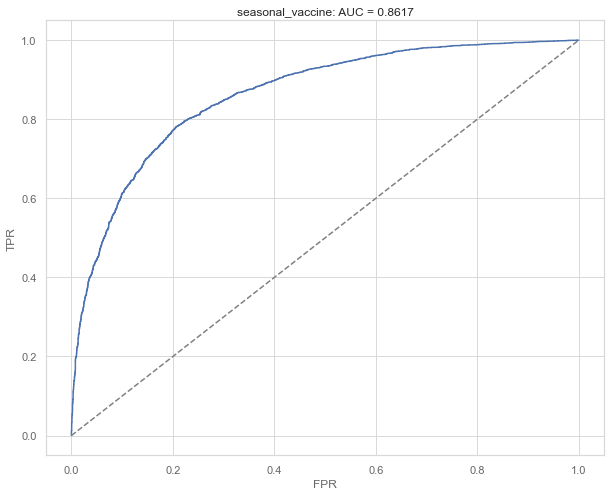

In [206]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_roc(
    y_test['seasonal_vaccine'], 
    predictions_se, 
    'seasonal_vaccine',
    ax=ax
)

In [207]:
roc_auc_score(y_test.seasonal_vaccine, predictions_se)

0.8616885268714828

Combined score

In [90]:
# Let's see the score combined of the two best predictions
roc_auc_score(y_test, np.hstack((predictions_h1, predictions_se)))

0.8655987194090375

Retraining on the full dataset

Seasonal flu

In [33]:
final_model_se.fit(train, labels.seasonal_vaccine)

In [34]:
# Engineering test features
def good_opinion_h1n1(test):  
    if test['opinion_h1n1_vacc_effective'] > 3:
        return 1
    else:
        return 0
    
    
def good_opinion_season(test):  
    if test['opinion_seas_vacc_effective'] > 3:
        return 1
    else:
        return 0

test['good_opinion_h1n1'] = test.apply(lambda test: good_opinion_h1n1(test), axis=1)

test['good_opinion_season'] = test.apply(lambda test: good_opinion_season(test), axis=1)

In [35]:
final_se = final_model_se.predict_proba(test)

CatBoostError: Invalid cat_features[14] = 37 value: index must be < 37.

In [ ]:
final_se = final_se[:,1].reshape(-1,1)

h1n1

In [ ]:
final_model.fit(train, labels.h1n1_vaccine)

In [ ]:
final_h1 = final_model.predict_proba(test)

In [ ]:
final_h1 = final_h1[:,1].reshape(-1,1)

In [96]:
submission_df = pd.read_csv(r"C:\Users\jvrdo\Downloads\submission_format.csv", 
                            index_col="respondent_id")

In [ ]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = final_h1
submission_df["seasonal_vaccine"] = final_se

submission_df.head()

In [ ]:
# Saving my submission as a csv file
submission_df.to_csv('my_submission_optuna2.csv')

In [37]:
# Loading data containing features
df_features = pd.read_csv(r"C:\Users\jvrdo\Downloads\training_set_features.csv")

# Loading data containing target variables
df_target = pd.read_csv(r"C:\Users\jvrdo\Downloads\training_set_labels.csv")

In [38]:
# Joining feature and target dataframe
df = pd.merge(df_features, df_target, how="inner")

In [47]:
# Dropping respondent_id from the original dataframe (df)
df.drop("respondent_id", axis =1, inplace=True)

In [60]:
from sklearn.ensemble import StackingClassifier

Ensamble>

In [130]:
train

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,-0.661324,-1.974363,-0.207526,-1.516432,-0.267608,-2.131558,-0.730282,1.395458,0.688295,-0.234668,...,0,0,0,0,0,0,0,0,0,0
1,1.508852,1.177796,-0.207526,0.612871,-0.267608,0.459236,-0.730282,1.395458,0.688295,-0.234668,...,0,0,0,0,0,0,1,0,0,0
2,-0.661324,-0.398284,-0.207526,0.612871,-0.267608,-2.131558,-0.730282,-0.697337,-1.392563,-2.164246,...,0,0,0,0,0,0,0,0,1,0
3,-0.661324,-0.398284,-0.207526,0.612871,-0.267608,0.459236,1.331413,-0.697337,-1.392563,-0.234668,...,0,0,0,0,0,0,0,0,0,0
4,0.423764,-0.398284,-0.207526,0.612871,-0.267608,0.459236,1.331413,-0.697337,0.688295,-0.234668,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0.423764,-1.974363,-0.207526,0.612871,-0.267608,-2.131558,-0.730282,1.395458,-1.392563,-0.234668,...,0,0,0,0,0,0,0,0,0,0
26703,-0.661324,1.177796,-0.207526,0.612871,-0.267608,0.459236,-0.730282,-0.697337,-1.392563,1.694911,...,0,0,0,0,0,0,0,0,0,0
26704,0.423764,1.177796,-0.207526,0.612871,3.655003,0.459236,1.331413,-0.697337,0.688295,-0.234668,...,0,0,0,0,0,0,0,0,0,0


In [22]:
from mlxtend.classifier import StackingCVClassifier 
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])

In [23]:
train[num_cols]

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,-0.661324,-1.974363,-0.207526,-1.516432,-0.267608,-2.131558,-0.730282,1.395458,0.688295,-0.234668,...,-0.215502,1.017933,-0.673617,-0.967590,-0.218130,-1.537966,-1.125614,-0.039863,-1.126271,-0.556137
1,1.508852,1.177796,-0.207526,0.612871,-0.267608,0.459236,-0.730282,1.395458,0.688295,-0.234668,...,-0.215502,1.017933,1.054473,1.275655,1.198256,0.048349,-0.442423,1.398827,-1.126271,-0.556137
2,-0.661324,-0.398284,-0.207526,0.612871,-0.267608,-2.131558,-0.730282,-0.697337,-1.392563,-2.164246,...,-0.215502,-1.050697,-0.673617,-0.967590,-0.926323,0.048349,-1.125614,-0.039863,1.466104,-0.556137
3,-0.661324,-0.398284,-0.207526,0.612871,-0.267608,0.459236,1.331413,-0.697337,-1.392563,-0.234668,...,-0.215502,-1.050697,-0.673617,0.527906,1.906448,0.841507,0.923959,-0.759208,-1.126271,-0.556137
4,0.423764,-0.398284,-0.207526,0.612871,-0.267608,0.459236,1.331413,-0.697337,0.688295,-0.234668,...,-0.215502,-1.050697,-0.673617,0.527906,-0.218130,-0.744809,-1.125614,1.398827,0.169916,-0.556137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0.423764,-1.974363,-0.207526,0.612871,-0.267608,-2.131558,-0.730282,1.395458,-1.392563,-0.234668,...,-0.215502,-1.050697,-0.673617,-0.967590,-0.926323,0.841507,-0.442423,-0.039863,-1.126271,-0.556137
26703,-0.661324,1.177796,-0.207526,0.612871,-0.267608,0.459236,-0.730282,-0.697337,-1.392563,1.694911,...,2.531716,1.017933,0.190428,-0.219842,-0.218130,0.841507,-1.125614,-0.759208,0.169916,-0.556137
26704,0.423764,1.177796,-0.207526,0.612871,3.655003,0.459236,1.331413,-0.697337,0.688295,-0.234668,...,-0.215502,-1.050697,0.190428,1.275655,-0.218130,0.841507,0.923959,-0.039863,-1.126271,-0.556137


In [36]:
from sklearn.svm import NuSVC, SVC
import xgboost as xg
from sklearn.ensemble import RandomForestClassifier

In [37]:
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

# Initializing Support Vector classifier
classifier1 = xg.XGBClassifier(
    gamma=1,
    learning_rate= 0.1,
    max_depth= 7,
    reg_lambda=0,
    objective="binary:logistic",
    colsample_bytree=0.5,
    subsample=0.8
)

# Initializing Multi-layer perceptron  classifier
classifier2 = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices, 
                          iterations=500,
    learning_rate=0.05745075659543725,
    random_strength=4,
    bagging_temperature=8,
    max_bin=5,
    grow_policy="Lossguide",
    min_data_in_leaf=7,
    max_depth=6,
    l2_leaf_reg=11.323094517862078,
    one_hot_max_size=10,
    auto_class_weights="Balanced")

# Initialing Nu Support Vector classifier
classifier3 = NuSVC(degree = 1, kernel = "rbf", nu = 0.25, probability = True)

# Initializing Random Forest classifier
classifier4 = RandomForestClassifier(n_estimators = 500, criterion = "gini", max_depth = 10,
                                     max_features = "auto", min_samples_leaf = 0.005,
                                     min_samples_split = 0.005, n_jobs = -1, random_state = 1000)

In [42]:
sclf = StackingCVClassifier(classifiers = [classifier1, classifier2, classifier3, classifier4],
                            shuffle = False,
                            use_probas = True,
                            cv = 5,
                            meta_classifier = LogisticRegression())

In [43]:
# Create list to store classifiers
classifiers = {"Xgboost": classifier1,
               "CatBoost": classifier2,
               "NuSVC": classifier3,
               "RF": classifier4,
               "Stack": sclf}

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    train,
    labels.h1n1_vaccine,
    test_size=0.30,
    shuffle=True,
    random_state=68
)


In [79]:
train[ord_cols]= oe.fit_transform(train[ord_cols])

In [45]:
# Train classifiers
for key in classifiers:
    # Get classifier
    classifier = classifiers[key]
    
    # Fit classifier
    classifier.fit(X_train, y_train)
        
    # Save fitted classifier
    classifiers[key] = classifier

C:\Users\jvrdo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

In [46]:
# Get results
results = pd.DataFrame()
for key in classifiers:
    # Make prediction on test set
    y_pred = classifiers[key].predict_proba(X_test)[:,1]
    
    # Save results in pandas dataframe object
    results[f"{key}"] = y_pred

# Add the test set to the results object
results["Target"] = y_test

C:\Users\jvrdo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jvrdo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jvrdo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

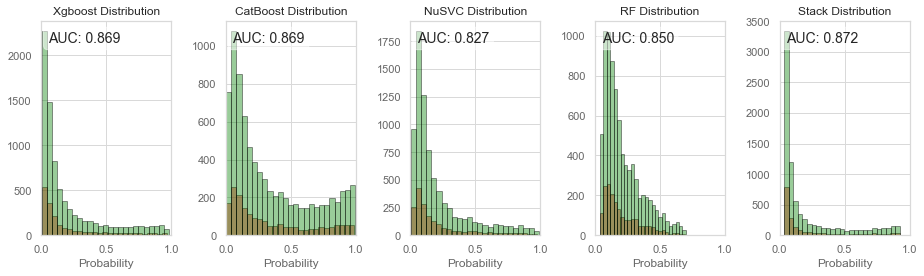

In [47]:
import seaborn as sns
# Probability Distributions Figure
# Set graph style
sns.set(font_scale = 1)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

# Plot
f, ax = plt.subplots(figsize=(13, 4), nrows=1, ncols = 5)

for key, counter in zip(classifiers, range(5)):
    # Get predictions
    y_pred = results[key]
    
    # Get AUC
    auc = roc_auc_score(y_test, y_pred)
    textstr = f"AUC: {auc:.3f}"

    # Plot false distribution
    false_pred = results[results["Target"] == 0]
    sns.distplot(false_pred[key], hist=True, kde=False, 
                 bins=int(25), color = 'red',
                 hist_kws={'edgecolor':'black'}, ax = ax[counter])
    
    # Plot true distribution
    true_pred = results[results["Target"] == 1]
    sns.distplot(results[key], hist=True, kde=False, 
                 bins=int(25), color = 'green',
                 hist_kws={'edgecolor':'black'}, ax = ax[counter])
    
    
    # These are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    # Place a text box in upper left in axes coords
    ax[counter].text(0.05, 0.95, textstr, transform=ax[counter].transAxes, fontsize=14,
                    verticalalignment = "top", bbox=props)
    
    # Set axis limits and labels
    ax[counter].set_title(f"{key} Distribution")
    ax[counter].set_xlim(0,1)
    ax[counter].set_xlabel("Probability")

# Tight layout
plt.tight_layout()

In [48]:
results

,Xgboost,CatBoost,NuSVC,RF,Stack,Target
0,0.057226,0.150490,0.055197,0.178566,0.068618,NaN
1,0.085866,0.218560,0.081595,0.166924,0.080999,NaN
2,0.055811,0.057204,0.179648,0.191582,0.061248,NaN
3,0.069756,0.130070,0.103419,0.112385,0.058807,NaN
4,0.018994,0.035790,0.035535,0.121413,0.044282,0.0
...,...,...,...,...,...,...
8008,0.031465,0.174081,0.030077,0.160163,0.065141,0.0
8009,0.016251,0.020638,0.061299,0.108060,0.041784,0.0
8010,0.017061,0.031297,0.053592,0.080915,0.039978,0.0
8011,0.213054,0.769164,0.293003,0.154745,0.272436,NaN


In [129]:
from sklearn.model_selection import GridSearchCV
# Tuning the meta classifier
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }



# Initialize GridSearchCV
grid = GridSearchCV(estimator = sclf, 
                    param_grid = param_grid, 
                    cv = 5,
                    scoring = "roc_auc",
                    verbose = 10,
                    n_jobs = -1)

# Fit GridSearchCV
grid.fit(X_train, y_train)

# Making prediction on test set
y_pred = grid.predict_proba(X_test)[:,1]

# Getting AUC
auc = metrics.roc_auc_score(y_test, y_pred)

# Print results
print(f"The AUC of the tuned Stacking classifier is {auc:.3f}")

Fitting 5 folds for each of 7 candidates, totalling 35 fits


ValueError: Invalid parameter 'C' for estimator StackingCVClassifier(classifiers=[XGBClassifier(base_score=0.5,
                                                booster='gbtree',
                                                callbacks=None,
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=0.5,
                                                early_stopping_rounds=None,
                                                enable_categorical=False,
                                                eval_metric=None, gamma=1,
                                                gpu_id=-1,
                                                grow_policy='depthwise',
                                                importance_type=None,
                                                interaction_constraints='',
                                                learning_rate=0.1, max_bin=256,
                                                max_ca...
                                                random_state=0, reg_alpha=0,
                                                reg_lambda=0, ...),
                                  <catboost.core.CatBoostClassifier object at 0x0000024B0FC414C0>,
                                  NuSVC(degree=1, nu=0.25, probability=True),
                                  RandomForestClassifier(max_depth=10,
                                                         max_features='auto',
                                                         min_samples_leaf=0.005,
                                                         min_samples_split=0.005,
                                                         n_estimators=500,
                                                         n_jobs=-1,
                                                         random_state=1000)],
                     cv=5, meta_classifier=LogisticRegression(), shuffle=False,
                     use_probas=True). Valid parameters are: ['classifiers', 'cv', 'drop_proba_col', 'meta_classifier', 'n_jobs', 'pre_dispatch', 'random_state', 'shuffle', 'store_train_meta_features', 'stratify', 'use_clones', 'use_features_in_secondary', 'use_probas', 'verbose'].

In [50]:
train

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,-0.661324,-1.974363,-0.207526,-1.516432,-0.267608,-2.131558,-0.730282,1.395458,0.688295,-0.234668,...,0,0,0,0,0,0,0,0,0,0
1,1.508852,1.177796,-0.207526,0.612871,-0.267608,0.459236,-0.730282,1.395458,0.688295,-0.234668,...,0,0,0,0,0,0,1,0,0,0
2,-0.661324,-0.398284,-0.207526,0.612871,-0.267608,-2.131558,-0.730282,-0.697337,-1.392563,-2.164246,...,0,0,0,0,0,0,0,0,1,0
3,-0.661324,-0.398284,-0.207526,0.612871,-0.267608,0.459236,1.331413,-0.697337,-1.392563,-0.234668,...,0,0,0,0,0,0,0,0,0,0
4,0.423764,-0.398284,-0.207526,0.612871,-0.267608,0.459236,1.331413,-0.697337,0.688295,-0.234668,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0.423764,-1.974363,-0.207526,0.612871,-0.267608,-2.131558,-0.730282,1.395458,-1.392563,-0.234668,...,0,0,0,0,0,0,0,0,0,0
26703,-0.661324,1.177796,-0.207526,0.612871,-0.267608,0.459236,-0.730282,-0.697337,-1.392563,1.694911,...,0,0,0,0,0,0,0,0,0,0
26704,0.423764,1.177796,-0.207526,0.612871,3.655003,0.459236,1.331413,-0.697337,0.688295,-0.234668,...,0,0,0,0,0,0,0,0,0,0


In [51]:
labels.h1n1_vaccine

respondent_id
0        0
1        0
2        0
3        0
4        0
        ..
26702    0
26703    0
26704    0
26705    0
26706    0
Name: h1n1_vaccine, Length: 26707, dtype: int64

In [55]:
test= pd.get_dummies(test, columns=cat_cols)

In [56]:
test

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53410,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
53411,3.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0
53412,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
test[ord_cols]= oe.fit_transform(test[ord_cols])

In [59]:
test[num_cols] = scaler.fit_transform(test[num_cols])

In [60]:
test

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,0.421757,1.175993,-0.207533,0.606459,-0.268244,0.458500,1.353178,-0.697199,0.678145,-0.238128,...,0,0,0,0,0,0,0,0,0,0
26708,-0.673138,-0.403987,-0.207533,-1.528981,-0.268244,-2.137013,-0.721845,-0.697199,-1.412815,-0.238128,...,0,0,0,0,0,0,0,1,0,0
26709,0.421757,1.175993,-0.207533,-1.528981,3.646654,0.458500,1.353178,1.395731,0.678145,-0.238128,...,0,0,0,0,0,0,0,0,0,0
26710,-0.673138,-0.403987,-0.207533,-1.528981,-0.268244,-2.137013,-0.721845,-0.697199,-1.412815,1.685624,...,0,0,0,0,0,0,0,0,0,0
26711,1.516652,-0.403987,4.251681,0.606459,-0.268244,0.458500,1.353178,1.395731,0.678145,-0.238128,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53410,-0.673138,-0.403987,-0.207533,0.606459,-0.268244,0.458500,-0.721845,-0.697199,0.678145,1.685624,...,0,0,0,0,0,0,0,0,0,0
53411,1.516652,-0.403987,-0.207533,0.606459,-0.268244,0.458500,1.353178,1.395731,0.678145,-0.238128,...,0,0,0,0,0,1,0,0,0,0
53412,-1.768033,-0.403987,-0.207533,-1.528981,-0.268244,-2.137013,-0.721845,-0.697199,-1.412815,-0.238128,...,0,0,0,0,0,0,0,0,0,0


In [61]:
test_preds= sclf.predict_proba(test)

In [63]:
test_preds = test_preds[:,1]

In [65]:
h1n1_test= test_preds

## Creating ensamlbe for seasonal flu

In [104]:
X_train, X_test, y_train, y_test = train_test_split(
    train,
    labels.seasonal_vaccine,
    test_size=0.30,
    shuffle=True,
    random_state=68
)


In [113]:
sclf_2 = StackingCVClassifier(classifiers = [classifier1_se, classifier2_se, classifier3_se, classifier4_se],
                            shuffle = False,
                            use_probas = True,
                            cv = 5,
                            meta_classifier = LogisticRegression())

In [114]:
from sklearn.ensemble import GradientBoostingClassifier
# Initializing Support Vector classifier
classifier1_se = xg.XGBClassifier(
    gamma=1,
    learning_rate= 0.1,
    max_depth= 7,
    reg_lambda=0,
    objective="binary:logistic",
    colsample_bytree=0.5,
    subsample=0.8
)

# Initializing Multi-layer perceptron  classifier
classifier2_se = CatBoostClassifier(verbose=False,  cat_features=categorical_features_indices, 
                          iterations=500,
    learning_rate=0.05745075659543725,
    random_strength=4,
    bagging_temperature=8,
    max_bin=5,
    grow_policy="Lossguide",
    min_data_in_leaf=7,
    max_depth=6,
    l2_leaf_reg=11.323094517862078,
    one_hot_max_size=10,
    auto_class_weights="Balanced")

# Initialing Nu Support Vector classifier
classifier3_se = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                            max_depth=3, random_state=68)

# Initializing Random Forest classifier
classifier4_se = RandomForestClassifier(n_estimators = 500, criterion = "gini", max_depth = 10,
                                     max_features = "auto", min_samples_leaf = 0.005,
                                     min_samples_split = 0.005, n_jobs = -1, random_state = 1000)

In [115]:
# Create list to store classifiers
classifiers_2 = {"Xgboost": classifier1_se,
               "CatBoost": classifier2_se,
               "GB_tree": classifier3_se,
               "RF": classifier4_se,
               "Stack": sclf_2}

In [116]:
# Train classifiers
for key in classifiers_2:
    # Get classifier
    classifier = classifiers_2[key]
    
    # Fit classifier
    classifier.fit(X_train, y_train)
        
    # Save fitted classifier
    classifiers_2[key] = classifier

C:\Users\jvrdo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\jvrdo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

In [117]:
# Get results
results_2 = pd.DataFrame()
for key in classifiers:
    # Make prediction on test set
    y_pred = classifiers[key].predict_proba(X_test)[:,1]
    
    # Save results in pandas dataframe object
    results[f"{key}"] = y_pred

# Add the test set to the results object
results_2["Target"] = y_test

In [125]:
test_preds_2= sclf_2.predict_proba(test)
test_preds_2 = test_preds_2[:,1]

C:\Users\jvrdo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jvrdo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


KeyError: 'GB_tree'

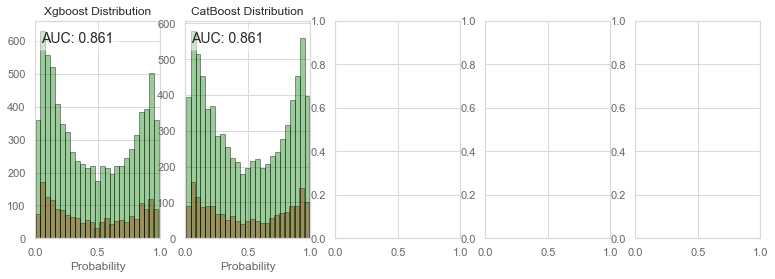

In [119]:
import seaborn as sns
# Probability Distributions Figure
# Set graph style
sns.set(font_scale = 1)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

# Plot
f, ax = plt.subplots(figsize=(13, 4), nrows=1, ncols = 5)

for key, counter in zip(classifiers_2, range(5)):
    # Get predictions
    y_pred = results[key]
    
    # Get AUC
    auc = roc_auc_score(y_test, y_pred)
    textstr = f"AUC: {auc:.3f}"

    # Plot false distribution
    false_pred = results[results["Target"] == 0]
    sns.distplot(false_pred[key], hist=True, kde=False, 
                 bins=int(25), color = 'red',
                 hist_kws={'edgecolor':'black'}, ax = ax[counter])
    
    # Plot true distribution
    true_pred = results[results["Target"] == 1]
    sns.distplot(results[key], hist=True, kde=False, 
                 bins=int(25), color = 'green',
                 hist_kws={'edgecolor':'black'}, ax = ax[counter])
    
    
    # These are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    # Place a text box in upper left in axes coords
    ax[counter].text(0.05, 0.95, textstr, transform=ax[counter].transAxes, fontsize=14,
                    verticalalignment = "top", bbox=props)
    
    # Set axis limits and labels
    ax[counter].set_title(f"{key} Distribution")
    ax[counter].set_xlim(0,1)
    ax[counter].set_xlabel("Probability")

# Tight layout
plt.tight_layout()

In [93]:
predictions_se_fin = predictions_se_fin[:,1]

In [94]:
predictions_se_fin

array([0.3181417 , 0.05232625, 0.63963895, ..., 0.26819249, 0.30653372,
       0.72545671])

In [99]:
h1n1_test.shape

(26708,)

In [126]:
submission_df["h1n1_vaccine"] = h1n1_test
submission_df["seasonal_vaccine"] = test_preds_2

submission_df

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.081886,0.276669
26708,0.045500,0.067985
26709,0.154835,0.745883
26710,0.605110,0.881999
26711,0.185520,0.387886
...,...,...
53410,0.255227,0.482889
53411,0.163228,0.242303
53412,0.141303,0.180148


In [127]:
submission_df.to_csv('my_submission_stacked_2.csv')